# MACHINE LEARNING APPROACH FOR THE PREDICTION OF THE STATUS OF TANZANIAN WELLS -> COMP4030 CW2 - Data Science and Machine Learning

**Thomas Cotter** and **Loo Yang Shen Jason**

This project is based on 'Pump It Up: Data Mining the Water Table', found [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/)



### Imports

Please import all of these packages (you may have to install some, installation scrips are not included in this file).

In [1]:
# Generic python packages
import os
import string
import pandas as pd # >= v1.3.5
import numpy as np # >= v1.24.5
import seaborn as sns # >= v0.12.2
import matplotlib.pyplot as plt # >= v3.5.1
import pickle

from shapely.geometry import Point # >= v2.0.1
import geopandas as gpd # >= 0.11.0
from geopandas import GeoDataFrame

# scikit-learn imports, scikit-learn >= v1.2.2
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report, f1_score
from sklearn.utils.class_weight import compute_sample_weight

import xgboost as xgb # >= v1.6.1
from catboost import CatBoostClassifier # >= v1.1.1

# Balancing the dataset.
# imblearn >= 0.10.1
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

import wandb # >= 0.14.0

# ROC Curve
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

## 1.0 Data Understanding & Statistical Analysis

This section details the steps we took to initially understand our data. We also produced some statistical analysis on each column.

Each of us took different steps to do this, and collated our findings at the end. Cells by one author will contain `Author [Author]` at the top. Cells without this tags were steps taken by both of us, unless specified.

### 1.1 Entire Dataset

This section looks at the entire dataset, using functions such as df.describe() and df.info(). We also look at the number of missing values in each column.

In [2]:
df_values = pd.read_csv('./datasets/train_features_water.csv')
df_labels = pd.read_csv('./datasets/train_labels_water.csv')
df = df_values.merge(df_labels, on='id', how='left')
print("SHAPE:", df.shape)
df.describe()

SHAPE: (59400, 41)


,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [3]:
# percent of data that has construction year 0
percent = df.loc[df['construction_year'] == 0].shape[0] / df['construction_year'].shape[0] * 100
print("%0.2f" % (percent))

34.86


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [5]:
total_nulls = df.isnull().sum()
total_obs = df.shape[0]
null_p = total_nulls[total_nulls > 0] / total_obs * 100
total_nulls = total_nulls[total_nulls > 0]
pd.concat([total_nulls, null_p], axis=1, keys=['Total', 'Percentage']).sort_values(by='Total', ascending=False)

,Total,Percentage
scheme_name,28166,47.417508
scheme_management,3877,6.526936
installer,3655,6.153199
funder,3635,6.119529
public_meeting,3334,5.612795
permit,3056,5.144781
subvillage,371,0.624579


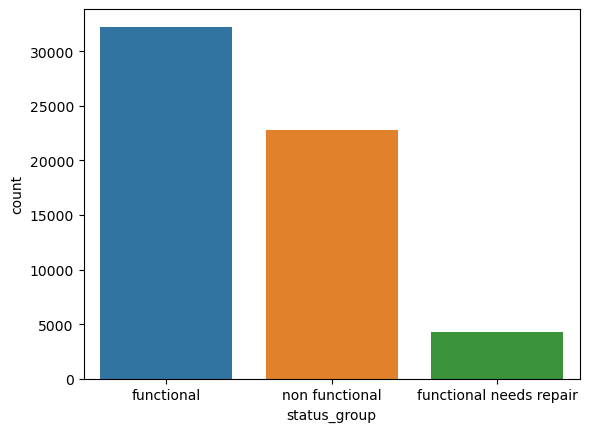

In [6]:
sns.countplot(data=df, x='status_group')
plt.show()

### 1.1 Check Each Columns Values & Quantity

In [7]:
# Author [Jason]

def display_col(df, column_name):
    print("----------%s----------" % (column_name))
    print(df[column_name].value_counts())
    print("Missing Values of %s column: %i" % (column_name, df[column_name].isna().sum()))
    print("Unique Values of %s column: %i" % (column_name, len(df[column_name].unique())))

for col in df.columns[1:len(df.columns)-1]:
    display_col(df, col)

----------amount_tsh----------
0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
6300.0          1
120000.0        1
138000.0        1
350000.0        1
59.0            1
Name: amount_tsh, Length: 98, dtype: int64
Missing Values of amount_tsh column: 0
Unique Values of amount_tsh column: 98
----------date_recorded----------
2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
             ... 
2011-09-11      1
2011-08-31      1
2011-09-21      1
2011-08-30      1
2013-12-01      1
Name: date_recorded, Length: 356, dtype: int64
Missing Values of date_recorded column: 0
Unique Values of date_recorded column: 356
----------funder----------
Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Rarymond Ekura               1
Justine Marwa                1
Municipal C

**1.1.1 Construction Year**

The construction year column is interesting due to the number of 0 values.

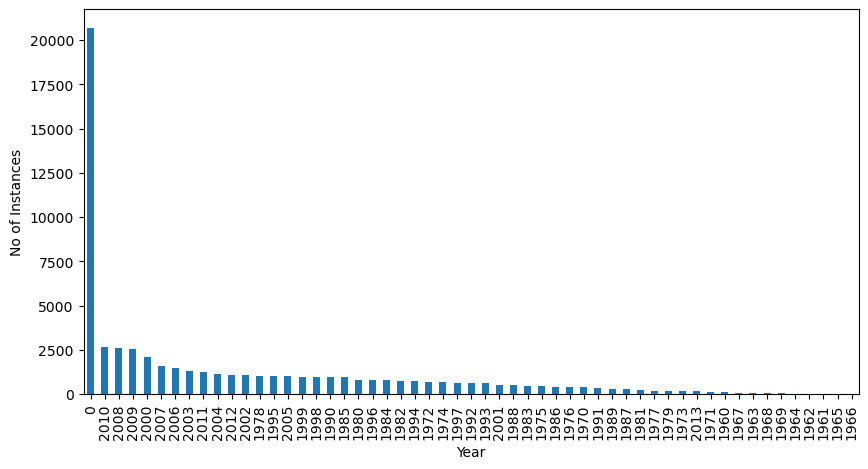

In [8]:
# Author [Jason]

plt.figure(figsize=(10,5))
df['construction_year'].value_counts().plot(kind="bar")
plt.xlabel("Year")
plt.ylabel("No of Instances")
plt.show()

Because of the number of 0's, we took some extra time to check the correlation of `construction_year` to other features, to see if we could use those features to impute the 0 values.

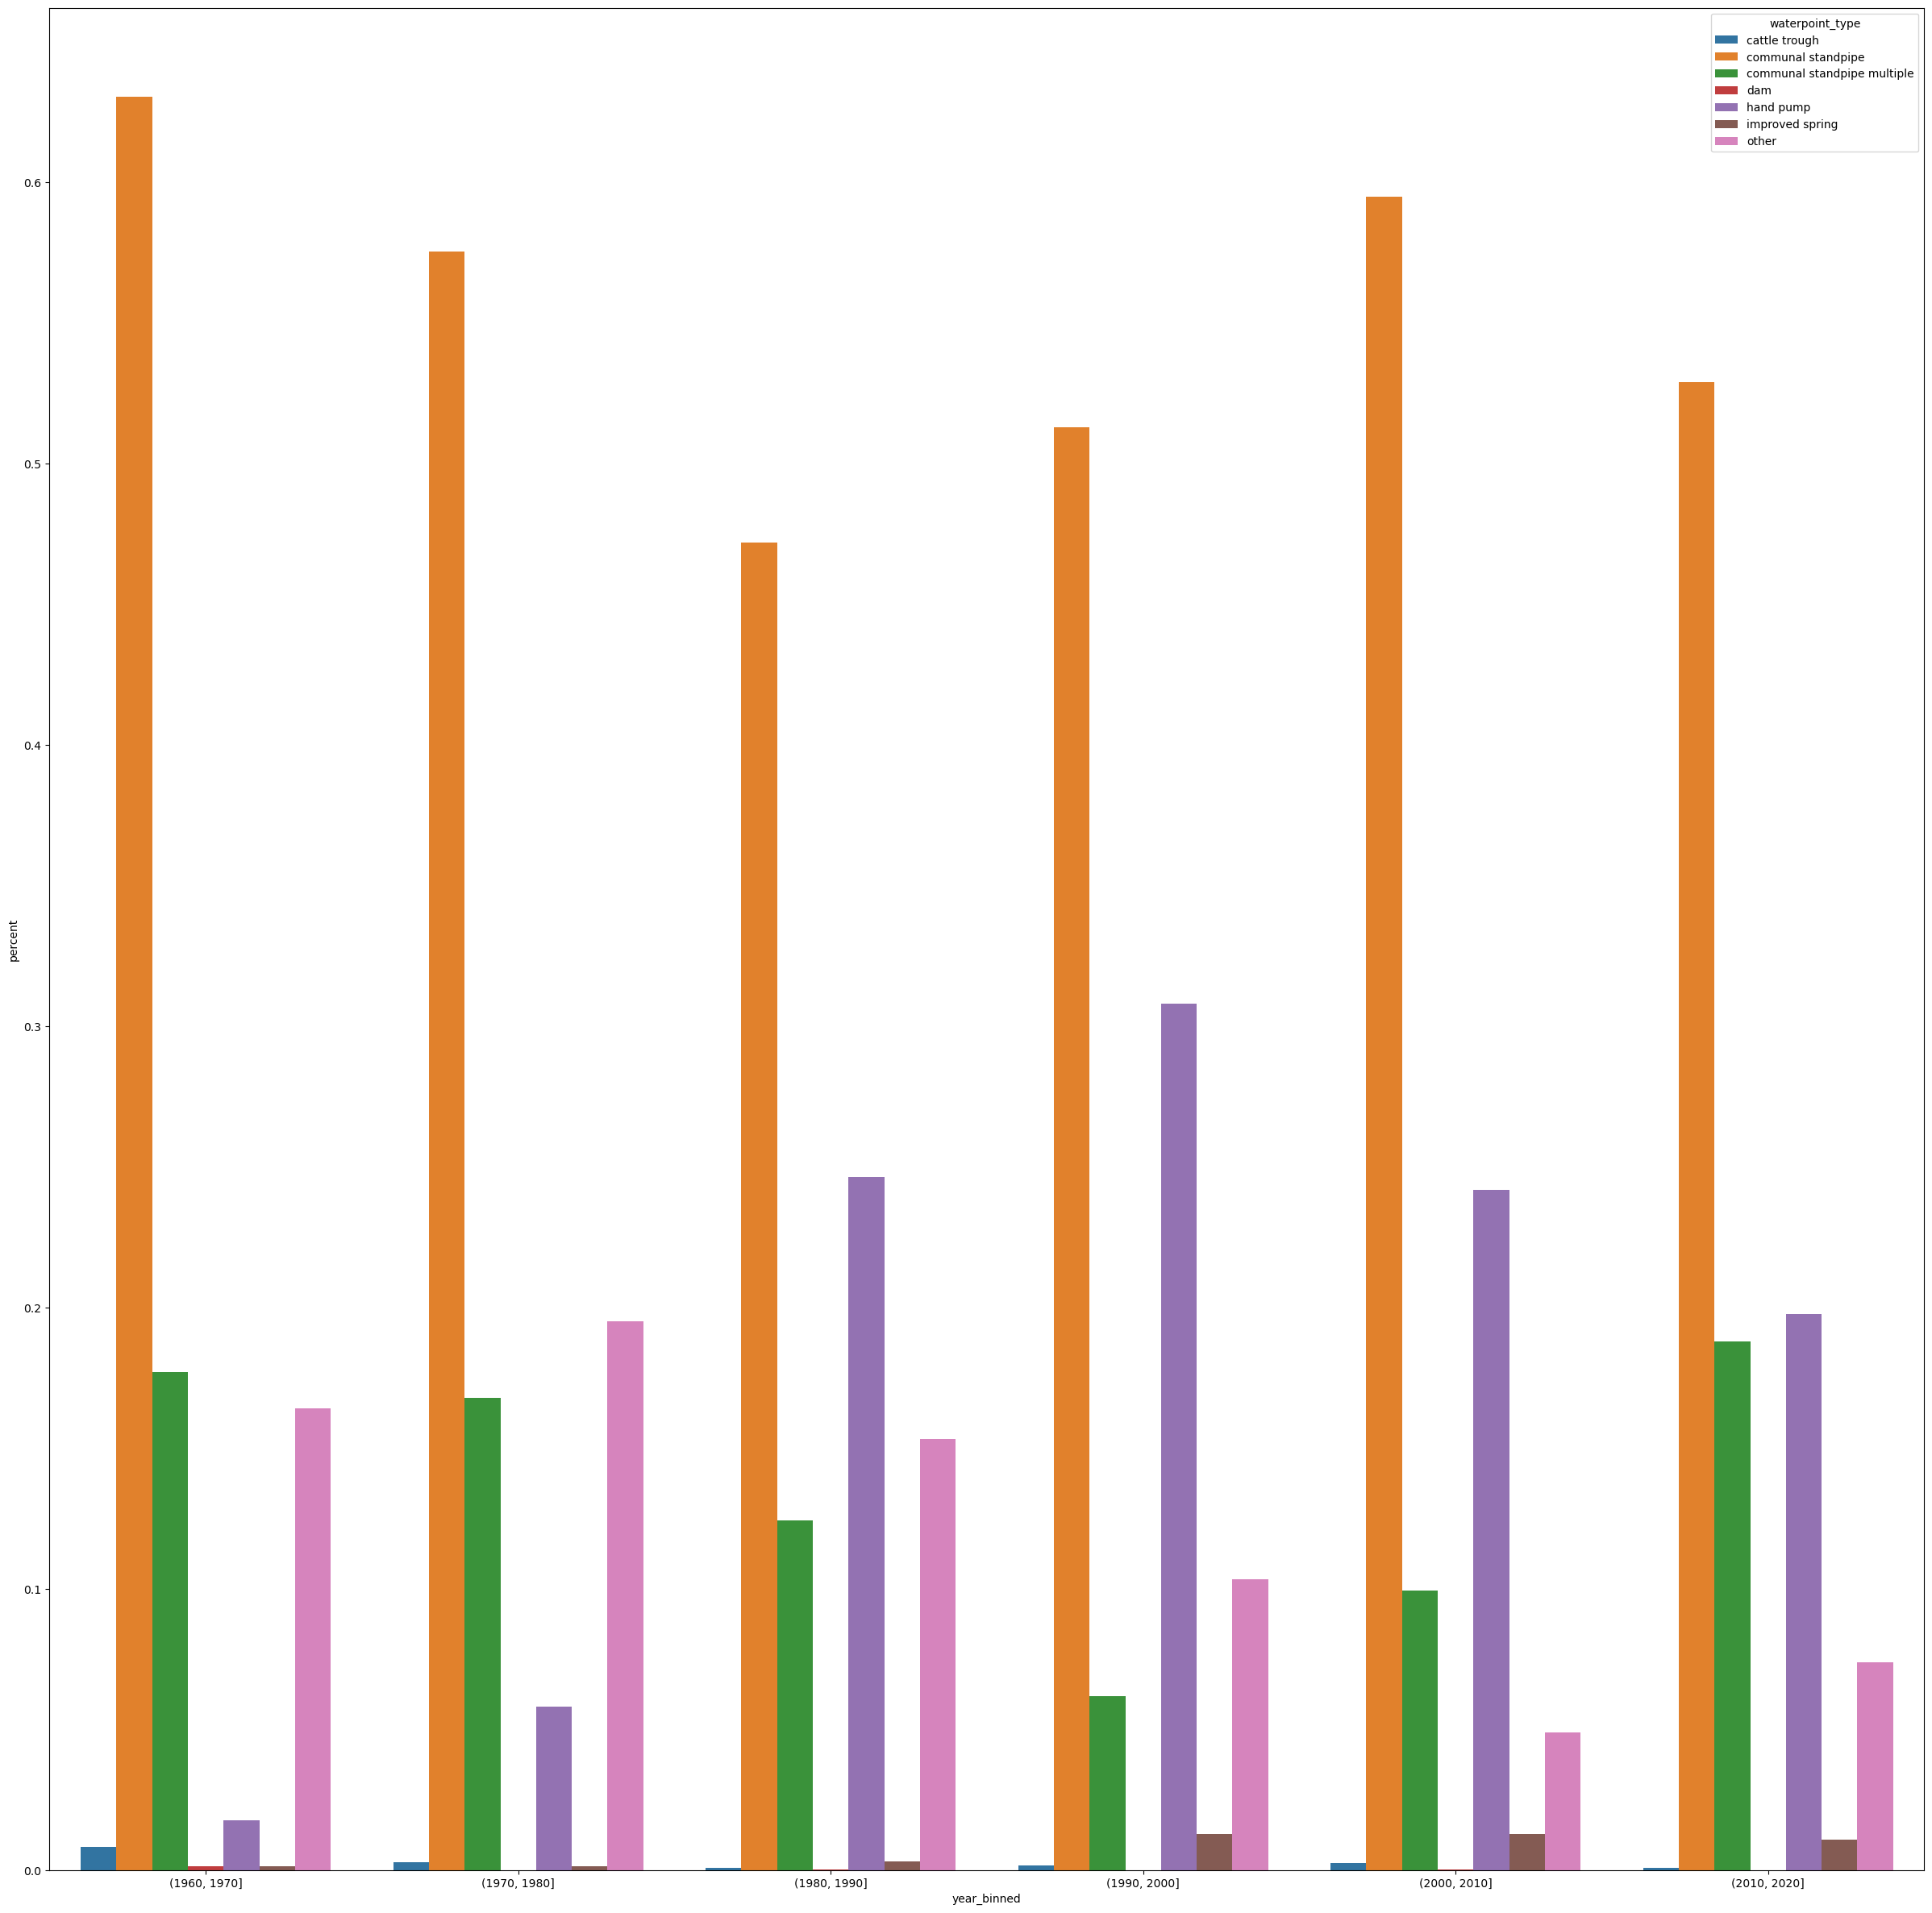

In [9]:
# Author [Tom]

# let's just drop the 0s for now

df_test = df.copy()
df_test = df_test[df_test['construction_year'] != 0]

bins = [1960, 1970, 1980, 1990, 2000, 2010, 2020]
df_test['year_binned'] = pd.cut(df['construction_year'], bins)

df_gby = df_test.groupby(['year_binned', 'waterpoint_type']).agg('size').reset_index(name='counts')
df_gby['percent'] = df_gby.groupby('year_binned')['counts'].transform(lambda x: x/sum(x))

fig, axs = plt.subplots(figsize=(30, 30))
sns.barplot(data=df_gby, x="year_binned", y='percent', hue='waterpoint_type')
plt.show()

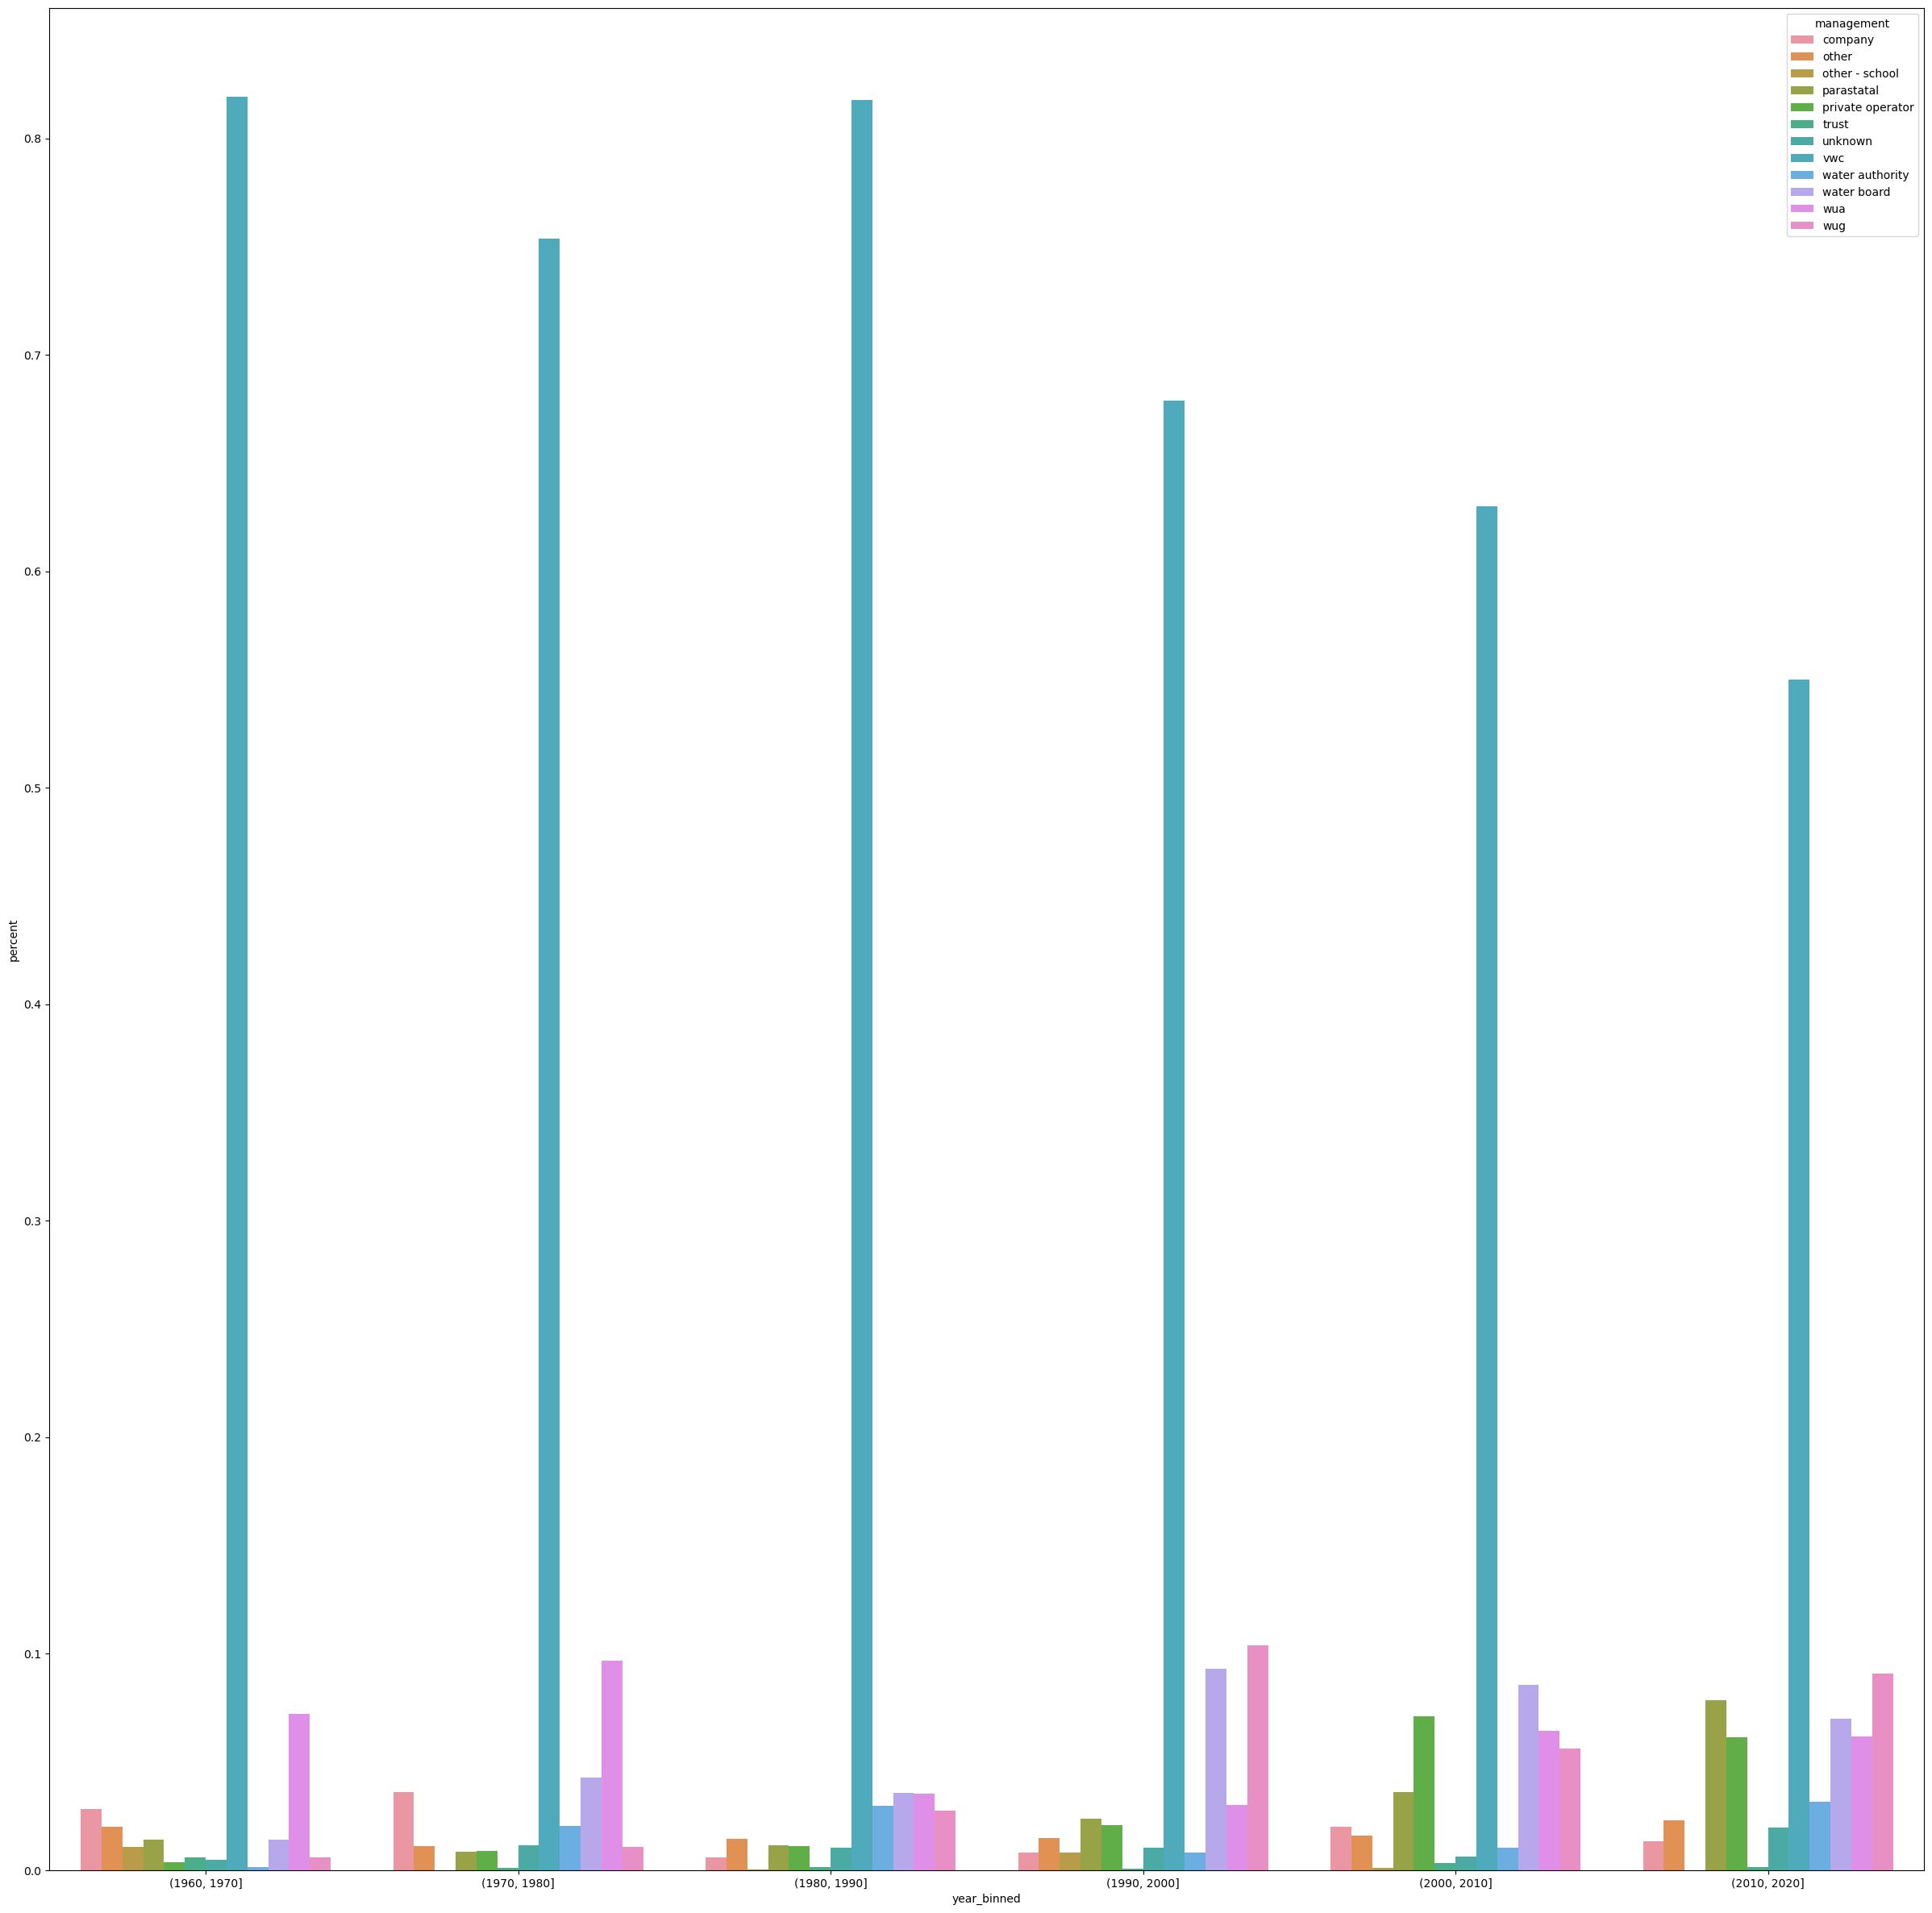

In [10]:
# Author [Tom]

df_gby = df_test.groupby(['year_binned', 'management']).agg('size').reset_index(name='counts')
df_gby['percent'] = df_gby.groupby('year_binned')['counts'].transform(lambda x: x/sum(x))

fig, axs = plt.subplots(figsize=(30, 30))
sns.barplot(data=df_gby, x="year_binned", y='percent', hue='management')
plt.show()

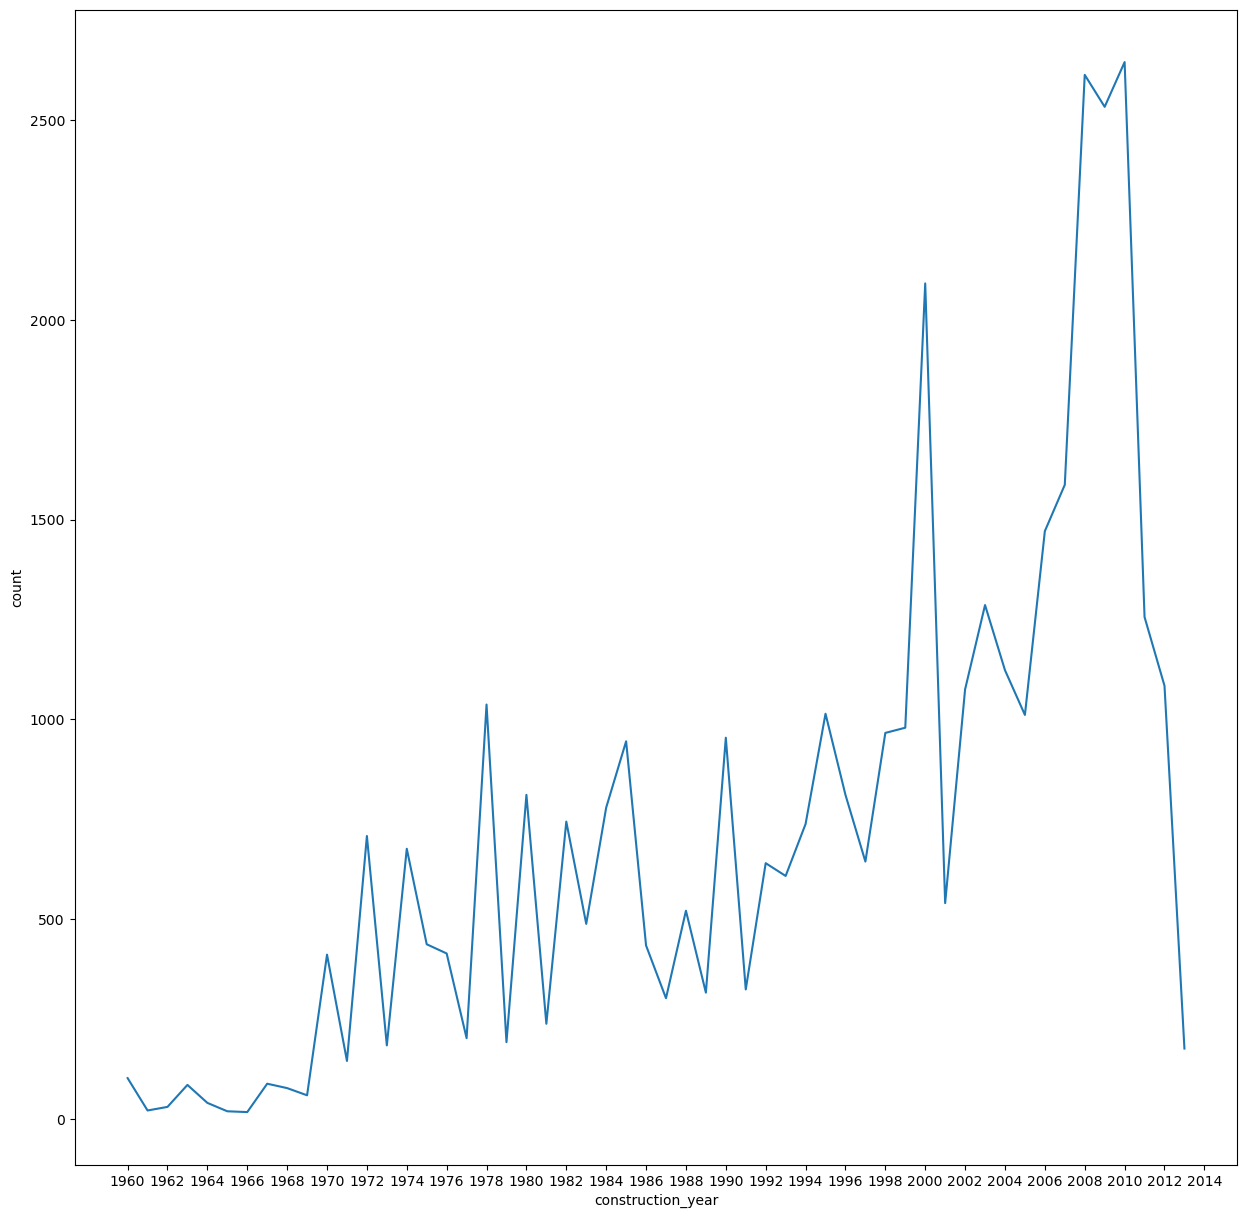

In [11]:
# Author [Tom]

df_years = df_test.groupby('construction_year').size().reset_index(name='count')
fig, ax = plt.subplots(figsize=(15, 15))

sns.lineplot(data=df_years, x='construction_year', y='count', ax=ax)
ax.xaxis.set_ticks(np.arange(1960, 2016, 2))
plt.show()

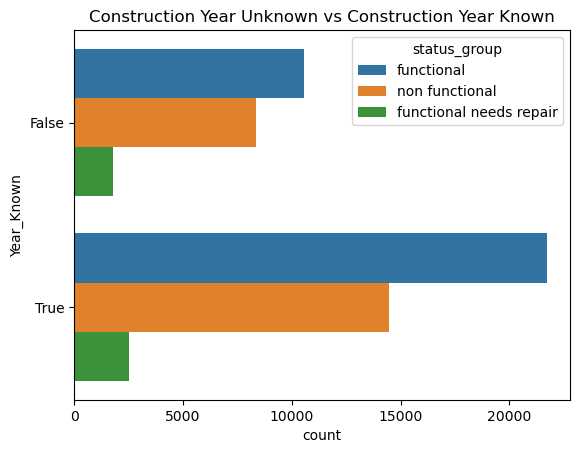

In [12]:
df_test = df.copy()
df_test['Year_Known'] = np.where(df_test['construction_year'] == 0, False, True)
sns.countplot(data=df_test, y='Year_Known', hue='status_group', dodge=1.0)
plt.title('Construction Year Unknown vs Construction Year Known')
plt.show()

**Repeated Columns**

Some of features are abstracted versions of other features, for example source, source_type & source_class all refer to the same thing. Statistical analysis of these columns can been seen below.

From this information, we can use feature selection algorithms to determine which one contains the most useful information, discarding the others. For example, we could use 'source_type' as the feature, and avoid using 'source' and 'source_class' in our models.

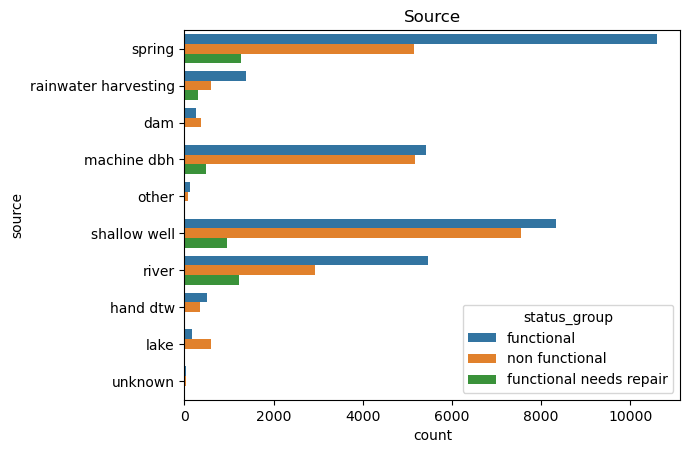

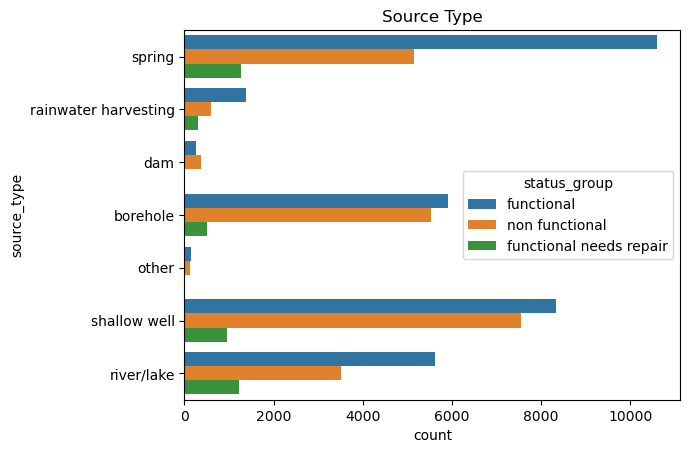

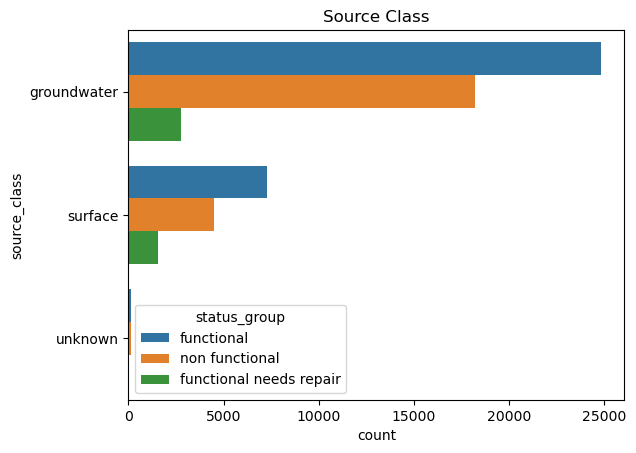

In [13]:
# Author [Jason]
sns.countplot(data=df, y='source', hue='status_group', dodge=1.0)
plt.title('Source')

plt.figure()
sns.countplot(data=df, y='source_type', hue='status_group', dodge=1.0)
plt.title('Source Type')

plt.figure()
sns.countplot(data=df, y='source_class', hue='status_group', dodge=1.0)
plt.title('Source Class')
plt.show()

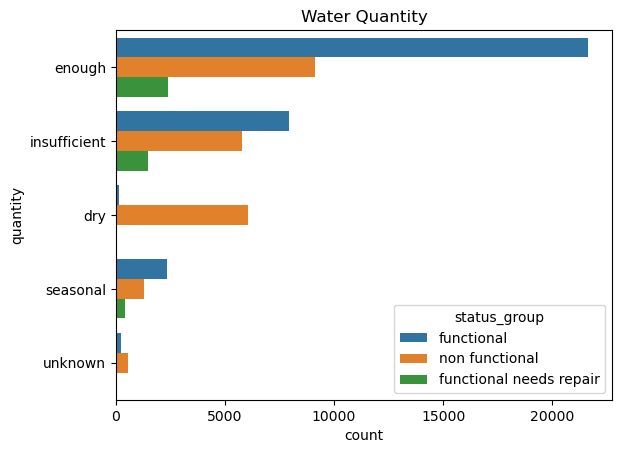

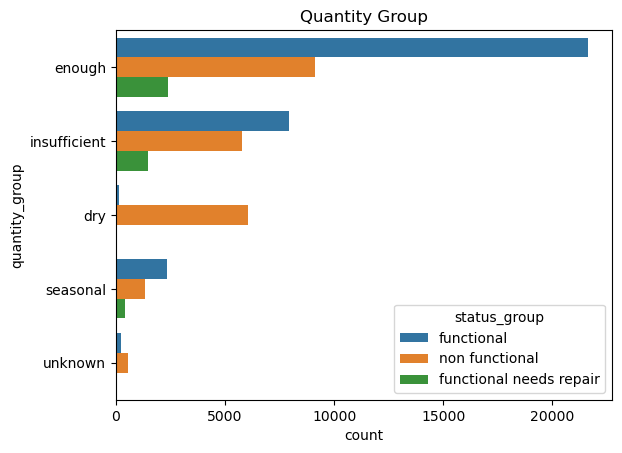

In [14]:
# Author [Jason]
sns.countplot(data=df, y='quantity', hue='status_group', dodge=1.0)
plt.title('Water Quantity')

plt.figure()
sns.countplot(data=df, y='quantity_group', hue='status_group', dodge=1.0)
plt.title('Quantity Group')
plt.show()

Text(0.5, 1.0, 'Quality Group')

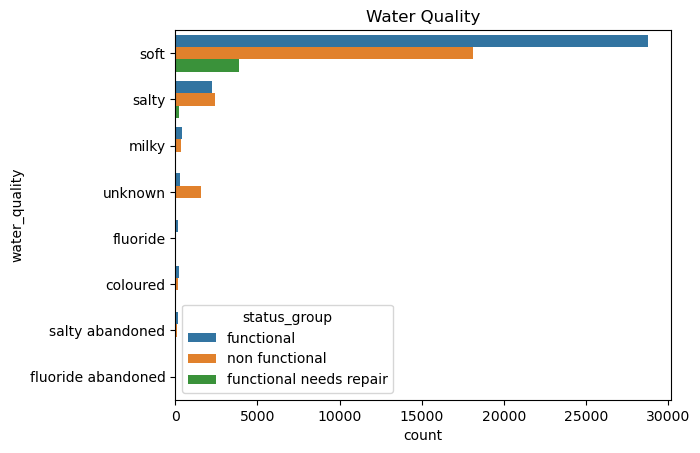

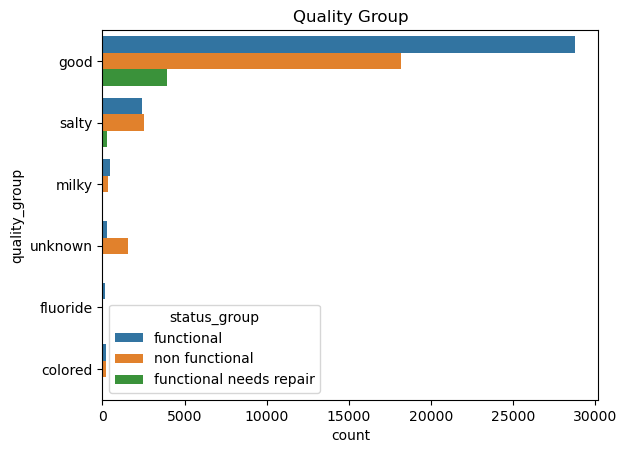

In [15]:
# Author [Jason]
sns.countplot(data=df, y='water_quality', hue='status_group', dodge=1.0)
plt.title('Water Quality')

plt.figure()
sns.countplot(data=df, y='quality_group', hue='status_group', dodge=1.0)
plt.title('Quality Group')

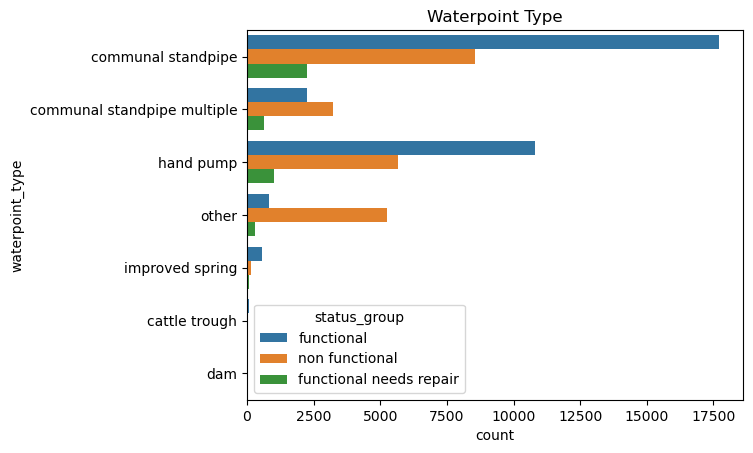

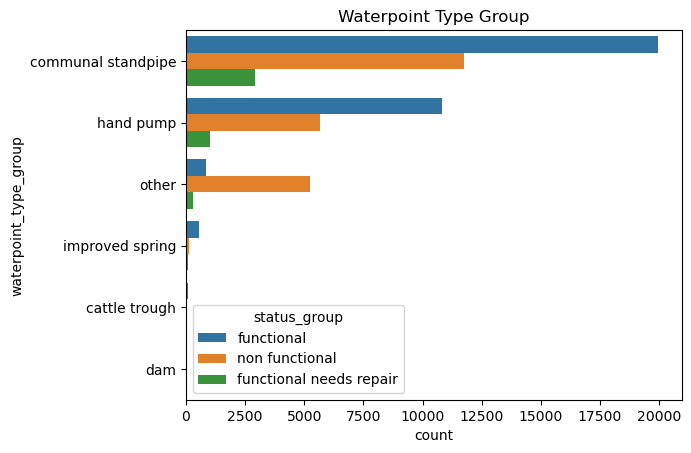

In [16]:
# Author [Jason]
sns.countplot(data=df, y='waterpoint_type', hue='status_group', dodge=1.0)
plt.title('Waterpoint Type')

plt.figure()
sns.countplot(data=df, y='waterpoint_type_group', hue='status_group', dodge=1.0)
plt.title('Waterpoint Type Group')
plt.show()

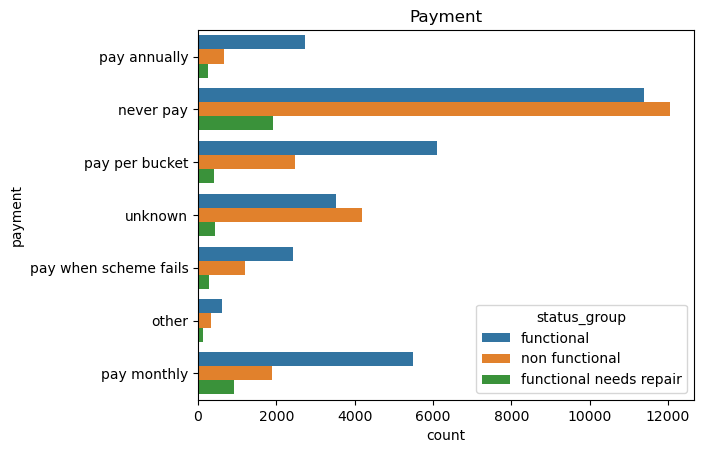

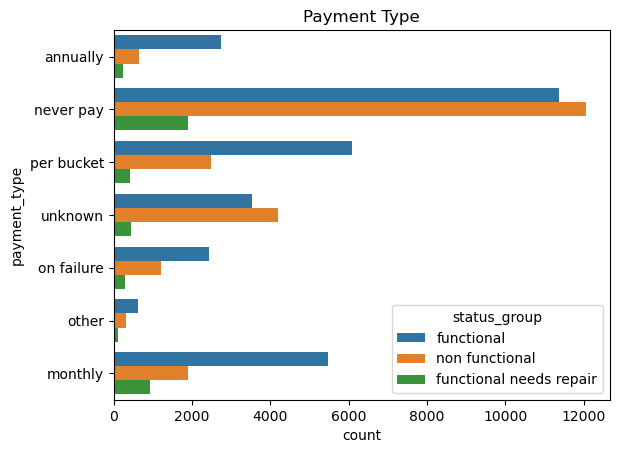

In [17]:
# Author [Jason]

sns.countplot(data=df, y='payment', hue='status_group', dodge=1.0)
plt.title('Payment')

plt.figure()
sns.countplot(data=df, y='payment_type', hue='status_group', dodge=1.0)
plt.title('Payment Type')
plt.show()

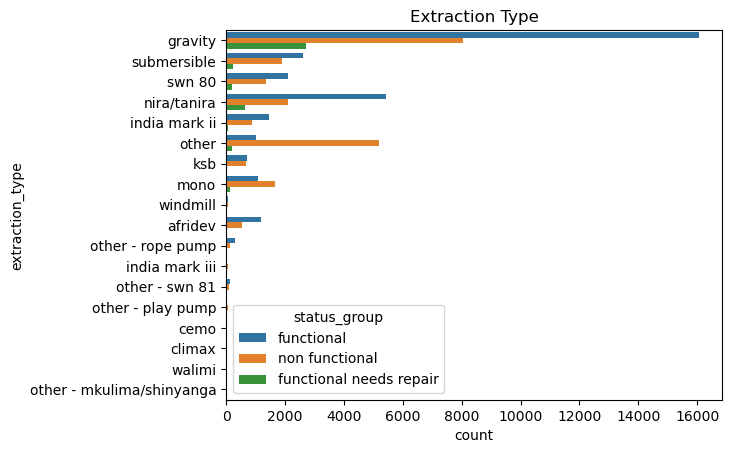

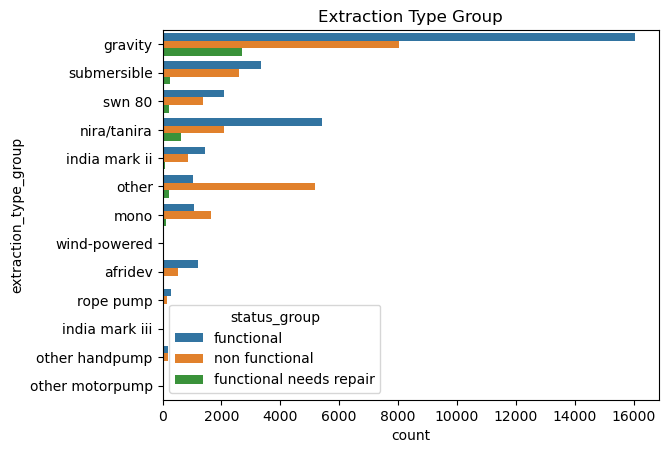

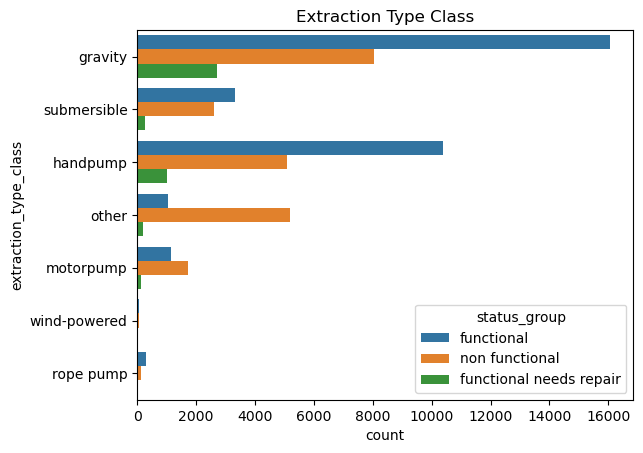

In [18]:
# Author [Jason]
sns.countplot(data=df, y='extraction_type', hue='status_group', dodge=1.0)
plt.title('Extraction Type')

plt.figure()
sns.countplot(data=df, y='extraction_type_group', hue='status_group', dodge=1.0)
plt.title('Extraction Type Group')

plt.figure()
sns.countplot(data=df, y='extraction_type_class', hue='status_group', dodge=1.0)
plt.title('Extraction Type Class')
plt.show()

## 2.0 Data Wrangling & Pre-processing

This section details the steps we took to wrangle, clean & pre-process our data in preparation for EDA & Modelling.

We both took different steps to do this, and collated our findings at the end. Cells by one author only will contain `Author [Author]` at the top. Cells without this tag were steps taken by both of us, unless specified.

In [19]:
df_values = pd.read_csv('./datasets/train_features_water.csv')
df_labels = pd.read_csv('./datasets/train_labels_water.csv')
df = df_values.merge(df_labels, on='id', how='left')

### 2.1 Imputation

This section details how we dealt with missing data in certain columns.

**2.1.1 Lat/Lon Imputation**

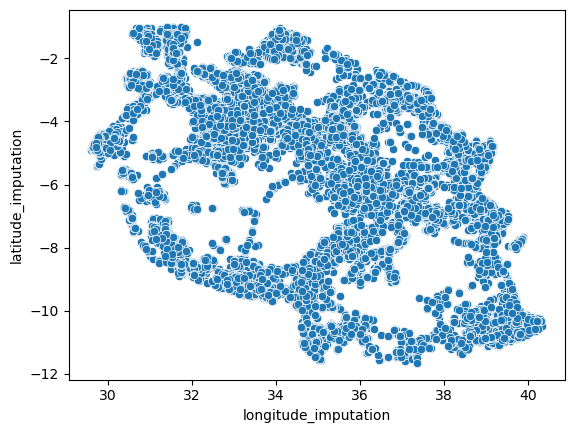

In [20]:
# Author [Jason]
df['longitude_imputation'] = df['longitude']
df['latitude_imputation'] = df['latitude']

df['longitude_imputation'] = df['longitude_imputation'].replace(0, np.nan)
df['longitude_imputation'] = df['longitude_imputation'].fillna(df.groupby('region')['longitude_imputation'].transform('mean'))

df['latitude_imputation'] = df['latitude_imputation'].replace(-2.000000e-08, np.nan)
df['latitude_imputation'] = df['latitude_imputation'].fillna(df.groupby('region')['latitude_imputation'].transform('mean'))

sns.scatterplot(data=df, x='longitude_imputation', y='latitude_imputation')
plt.show()

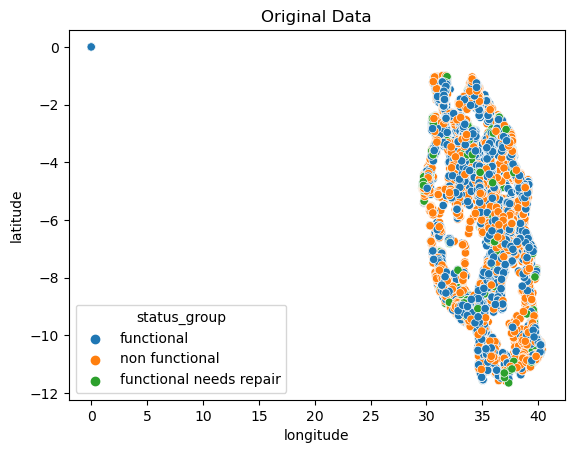

In [21]:
# Author [Tom]

sns.scatterplot(df, x='longitude', y='latitude', hue='status_group')
plt.title("Original Data")
plt.show()

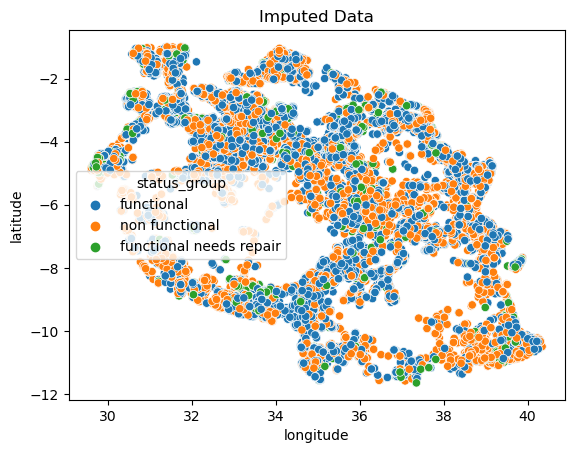

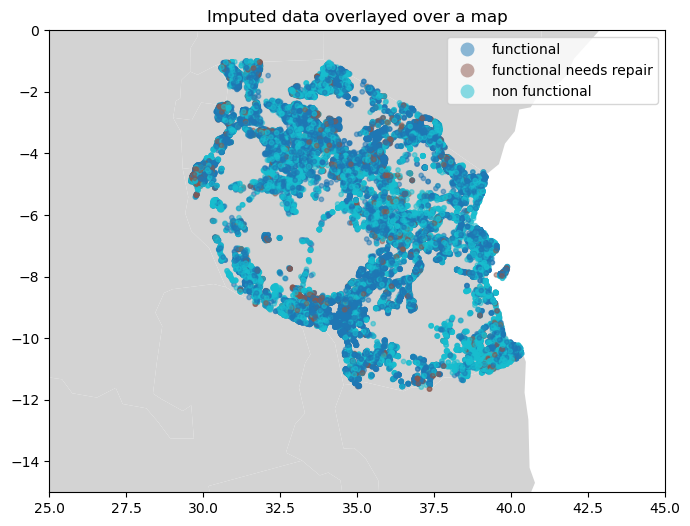

In [22]:
# Author [Tom]

df['longitude'].replace(0, np.nan, inplace=True)
df['longitude'] = df['longitude'].fillna(df.groupby(['region', 'lga','ward'])['longitude'].transform('mean'))
df['longitude'] = df['longitude'].fillna(df.groupby(['region', 'lga'])['longitude'].transform('mean'))
df['longitude'] = df['longitude'].fillna(df.groupby('region')['longitude'].transform('mean'))
df.loc[df['latitude'] == -2.000000e-08, 'latitude'] = np.nan
df['latitude'] = df['latitude'].fillna(df.groupby(['region', 'lga', 'ward'])['latitude'].transform('mean'))
df['latitude'] = df['latitude'].fillna(df.groupby(['region', 'lga'])['latitude'].transform('mean'))
df['latitude'] = df['latitude'].fillna(df.groupby('region')['latitude'].transform('mean'))

sns.scatterplot(df, x='longitude', y='latitude', hue='status_group')
plt.title("Imputed Data")

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = gdf.plot(ax=world.plot(figsize=(10, 6), facecolor="lightgrey"), column='status_group', alpha=0.5, legend=True, markersize=10);
ax.set_xlim(25, 45)
ax.set_ylim(-15, 0)
plt.title('Imputed data overlayed over a map')

df.drop('geometry', axis=1, inplace=True)
plt.show()

**2.1.2 Population**

The population feature contains a large amount of 0 values. We can impute these in a similar method to the latitude and longitude. Futhermore, certain subvillages have been record having different populations. Although this may be due to when the data was recorded (in theory it was all recorde at the same time, but who knows), we have made each population the mean of the subvillage of that population.

In [23]:
# Author [Tom]

df['population_original'] = df['population']

df['population'] = df['population'].replace(0, np.nan)

df['population'] = df['population'].fillna(df.groupby(['region', 'lga', 'ward'])['population'].transform('mean'))
df['population'] = df['population'].fillna(df.groupby(['region', 'lga', 'ward'])['population'].transform('mean'))
df['population'] = df['population'].fillna(df.groupby(['region', 'lga'])['population'].transform('mean'))
df['population'] = df['population'].fillna(df.groupby('region')['population'].transform('mean'))
df['population'] = df['population'].fillna(df.groupby('basin')['population'].transform('mean'))

df['population_mean'] = df.groupby(['basin', 'region', 'ward', 'lga', 'subvillage'])['population'].transform('mean')
df['population_mean'] = df.groupby(['basin', 'region', 'ward', 'lga'])['population'].transform('mean')
df['population_mean'] = df.groupby(['basin', 'region', 'ward'])['population'].transform('mean')
df['population_mean'] = df.groupby(['basin', 'region'])['population'].transform('mean')

**2.1.3 Permit**

The n/a values will be replaced with "Unknown"

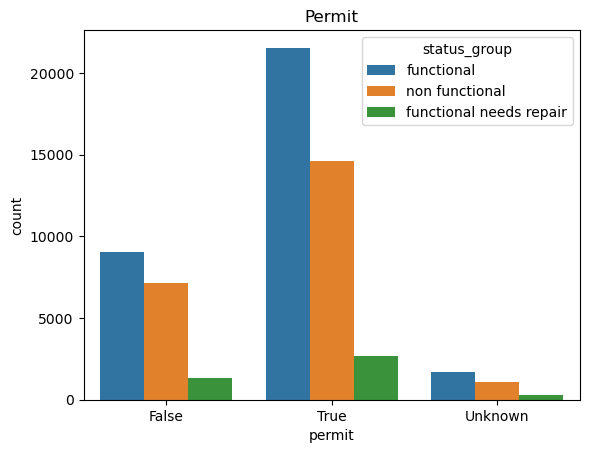

In [24]:
# Author [Jason]

df['permit'] = df['permit'].fillna("Unknown")
sns.countplot(data=df, x='permit', hue='status_group', dodge=1.0)
plt.title('Permit')
plt.show()

**2.1.4 Public Meeting**

The NaNs will be replaced with "Unknown"

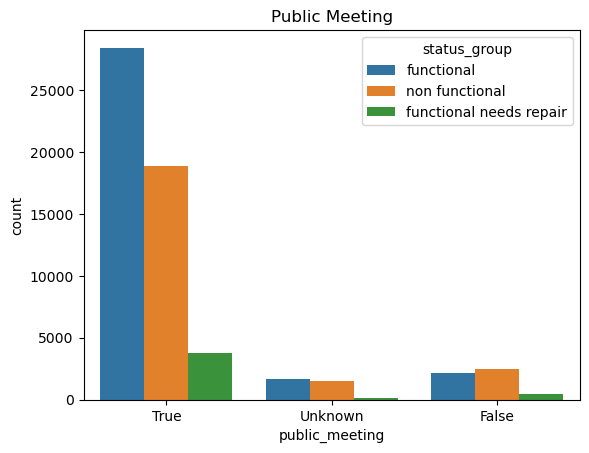

In [25]:
df['public_meeting'] = df['public_meeting'].fillna("Unknown")
sns.countplot(data=df, x='public_meeting', hue='status_group', dodge=1.0)
plt.title('Public Meeting')
plt.show()

### 2.2.0 Binning of Values in Columns

In this section, we looked at columns with lots of unique values and attempted to categorized those into fewer categories.

**2.2.1 Funder & Installer**

The values in both the installer and funder columns are quite similar. We decided on these categories to classify each value into.

    - Foreign Aid
    - National Government (Government of Tanzania)
    - Local Government (Local Councils)
    - Religious Entities
    - Private Companies
    - Charities
    - Schools
    - Unknown

Unfortunately, any automatic methods to do do not work on our dataset as it is so specific to Tanzania and the slang / abbrevations only known to Tanzanian people. We tried to use NER (https://spacy.io/api/entityrecognizer), but it could not classify the strings correctly.

The list of values that comprise each class can be seen below. We have made some assumptions:

    - DWE stands for Distric Water Engineer. When on it's own this is classed as Local Gov, however it it often grouped with other parties such as NORAD. When it is grouped, the other entity takes priority.
    - RWE (regional WE) are government entities
    - Some funders are the water supply from which the water comes. These have been classified as private entities as we do not know the economical structure of water companies in Tanzania.
    - Any acroynyms that are similar are classed as the same acryonym (within reason): 'Rwssp' = 'Rwsssp', 'Rssp', 'Wrssp'.
    - Any words in Swahili are translated using an online translator. We cannot guarantee the accuracy of these translations.

Tom.

In [26]:
# Author [Tom]

foreign = ['Danida', 'Germany Republi','Netherlands', 'Norad','Jica', 'Jaica',
          'Nethalan', 'Swedish', 'Germany','China Government' 'Dwe/norad', 'Tz Japan',
          'European Union', 'Dads', 'Holland', 'Swiss If', 'Jika', 'Nethe', 'Dadis',
          'Norad/ Kidep', 'The People of Japan', 'Finland Government', 
          'A/co Germany', 'Us Embassy', 'Finland', 'Jeica', 'Aco/germany',  'Canada',
          'Belgian Government', 'People Of Japan', 'World Bank', 'British Colonial Government',
          'France', 'Gaica', 'U.S.A', 'Greec', 'Sweden', 'Japn Embassy',
          'Colonial Government', 'Japan Aid', 'Italy Government', 'Usa Embassy', 'China Government',
           'Watu Wa Ujerumani',  'Norad /government', 'Un', 'The People Of Japan', 'Eu/acra',
           'Ubalozi Wa Marekani', 'Franc', 'Comune Di Roma', 'Japan Food',  'Netherland', 'Korea', 'Japan Embassy',
           'Danida /government', 'World Bank/government', 'Unhcr/government', 'Norad/government', 'Japan Government', 'Irish Government',
           'Egypt Government',  'Iran Gover', 'Italy', 'British Tanza',  'People From Japan','Norad/ Tassaf Ii',
           'Niger', 'Morad', 'Sweeden', 'Dqnida', 'Holand', 'Norad/ Tassaf', 'Foreigne', 
           'Watu Wa Marekani', 'Italian', 'Natherland', 'Ubalozi Wa Japani', 'Japan  Food Aid Counter Part', 
           'Embasy Of Japan In Tanzania', 'People From Egypt', 'Daida', 'Nerthlands', 'Norad/rudep', 'Norad/japan', 'Netherla', 'People Of Sweden',
           'Canada Aid', 'Unhcr/danida', 'Danid', 'DANID', 'DA', 'Egypt Technical Co Operation', 'Eu',
           'Irish Ai', 'Friend From Un', 'Japan', 'Grobal resource alliance', 'Japan Food Aid', 'Ddca',
           'WOULD BANK', 'Belgiam Government', 'NORAD/', 'China', 'JAICA CO', 'AUSTRALIA', 'Belgij',
           'ITALI', 'DENISH', 'IRAN GOVERN', 'NIRAD', 'Word Bank', 'Britain', 'British government',
           'WORLD NK', 'Chinese', 'Wizra ya maji na egypt', 'Hilfe Fur Bruder', 'DANIDS', 'DANNIDA',
           'Italian government', 'GERMAN', 'Word bank', 'Tanz/Egypt technical coopera',
           'WORDL BANK',
          ]
gov = ['Government Of Tanzania', 'Rwssp', 'Ministry Of Water',  'Lga', 'Dwsp',
        'Rural Water Supply And Sanitat', 'Wsdp','Tanza', 'Kuwait', 'Finida German Tanzania Govt', 
       'Dwssp', 'Cipro/government', 'Water Board',  'Tanzania', 'Isf/government', 'Rwsp',
       'Government/ Community', 'Finidagermantanzania Govt', 'Government/ World Bank',  'Member of Parliament',
       'Government /tassaf',  'Rwsssp',  'Tassaf/ Danida', 'Rwssp/wsdp', 'Ministry of Education',
        'Rssp','Koica and Tanzania Government','Ministry of Water', 'Dhv', 'Water', 'Rudep', 'W.B',
       'Tassaf', 'Undp', 'Gtz', 'Padep', 'National Rural','Idara Ya Maji',  'Dwe/norad', 'Serikali', 
       "Dhv\\norp",'Ifad','Tanzakesho', 'Dhv Moro', 'Rural Water Supply And Sanita', 'National Rural And Hfa',
       'Dhv/gove', 'Bffs', 'Tassaf Ii', 'Parastatal','Ministry Of Education', 'Wrssp', 'Tcrs /government',
       'Domestic Rural Development Pro', 'Rural Drinking Water Supply', 'Kaemp' ,'Tasaf And Lga',
       'Tasaf Ii' ,'Tasae', 'Taasaf', 'Isf / Tasaff','Tasaf And Lga', 'Tasaf And Mmem',
       'Tasaf 1', 'Tasaf/tlc', 'Tasa', 'Rural Water Department','Water Sector Development',
       'Water Department', 'Domestic Water Supply Project','District Rural Project', 'Vgovernment', 
       'Government /sda', 'Misri Government','Government And Community', 'Government/tassaf',
       'Government/tcrs','Government /world Vision', 'Government', 'Handeni Trunk Main(',
       'Domestic Rural Development Pr',  'Ministry Of Agricultura','Ministry Of Healthy', 'Rwssp Shinyanga',
       'Government Of Misri', 'Tassaf I',  'Overnment',  'Rudep/norad','Rudep /dwe', 
       'Tasf', 'Ded/rwssp', 'Dwe/rudep', 'Health  Ministry', 'Go', 'Dh',
       'Ridep', 'Tredep', 'Kirdep', 'Tridep', 'Kidep', 'Redep', 'Padep(mifugo)',
       'Dasip', 'Pidp', 'Asb', 'Ukiligu', 'Rdc', 'Imf', 'Sao H',  'Benguka', 'Dasp', 'Healt', 'Mem', 'Cbhi',
       'Nsc', 'Ddp', 'Hesawz', 'Dbspe', 'Tanapa', 'Tanap', 'Pmo', 'Simmors', 'Wizara', 'Doddea', 'Tirdo',
        'Rural Water Supply', 'Dassip', 'Sswp', 'Tanroad', 'Tpp', 'Wajerumani', 'Tasef', 'Tanzania /egypt',
       'Treedap', 'Prodap', 'National Park',  'Afya Department Lindi Rural',
       'Chama Cha Ushirika', 'Wdsp', 'Tanload', 'Hesswa', 'Hesawza','Hewawa', 'Hewasa', 'Isf/gvt', 'Hesawwa',
       'Drwssp', 'Tanzania Egypt Technical Co Op', 'Dagida', 'Hesawa', 'He', 'RWE', 'Central government',
        'Gover', 'Gove', 'Distri', 'Centr', 'MWE', 'Central govt', 'GOVER', 'Central Government',
         'Region water Department',  'RWE/DWE', 'MWE &', 'Wizara ya maji', 'Tanzania Government', 'KIDP',
       'GOVERN', 'TAWASA',  'TAN PLANT LTD', 'GEOTAN', 'NORA','central government', 'Tanz', 'UKILIG',
       'RWE /Community', 'CENTRAL GOVERNMENT', 'RW', 'Canada na Tanzania', 'RUDEP/', 'Ministry of water engineer',
       'RWE/ Community', 'RUDE', 'RWE/Community', 'ADRA /Government', 'Cental Government', 'TASAF/', 'WE',
       'Cebtral Government', 'UN ONE', 'KOICA', 'Tanzanian Government', 'TASSAF /TCRS', 'Plan Tanzania',
       'GOVERM', 'World banks','GOVERNME', 'RWE Community', 'Selikali', 'World Division', 'REDAP',
       'CIPRO', 'Governme', 'TANCRO', 'TAIPO', 'RWE/TCRS', 'Noshad', 'Handeni Trunk Main',
       'Mpango wa Mwisa', 'Centra Government', 'HEESAW', 'Governmen', 'HESAW', 'TASAF and Comunity',
       'DWE /TASSAF', 'HESAWS', 'Cetral government /RC', 'Centra govt',
      ]

local_gov = ['District Council', 'Mkinga Distric Coun', 'Mkinga Distric Cou', 'Kibaha Town Council',
            'Village Government', 'Songea District Council', 'Songea Municipal Counci',
            'Wua', 'Villagers', 'Village Council', 'Community', 'Muwsa', 'Halmashauri Ya Wilaya Sikonge',
             'Hsw', 'Vwc', 'Ncaa', 'Mkinga  Distric Cou', 'Losaa-kia Water Supply', 'Commu',
             'Kilindi District Co', 'Tabora Municipal Council',  'Kuwasa', 'Mbiuwasa',
             'Water User As', 'Tuwasa', 'Halmashauri', 'Village', 'Kilwater', 'Village Community',
             'Sekei Village Community', 'Singida Yetu', 'Sowasa', 'Makonde Water Population', 
             'Sumbawanga Munici', 'Bahewasa', 'Olgilai Village Community', 'Village Council/ Haydom Luther',
             'Halmashauri Ya Manispa Tabora', 'Lgcdg', 'Lowasa', 'Kinapa', 'Auwasa', 'Suwasa', 'Mzinga A',
             'Serikali Ya Kijiji', 'Regional Water Engineer Arusha', 'Water User Group', 'Ikela Wa', 'Council',
             'Sengerema District Council', 'Mtuwasa', 'Mamlaka Ya Maji Ngara', 'Halmashaur', 'Mbozi District Council',
             'Village Govt', 'Sauwasa', 'Kyela Council', 'Duwas' ,'Sangea District Council', 'Municipal Council',
             'Mheza Distric Counc', 'Ilkeri Village', 'Kigoma Municipal', 'Mwanga Town Water Authority',
             'Local', 'Villa', 'Mtuwasa And Community', 'Ngiresi Village Community', 'Liuwassa', 'Nduku Village',
             'Oldadai Village Community', 'Halmashauri Ya Wilaya', 'Mdrdp', 'Ndrdp', 'Government/school',
             'Muwasa', 'Dawasa', 'Suasa', 'Village Water Commission', 'Kigoma Municipal Council',
             'Villege Council', 'Village Council/ Rose Kawala', 'Wb / District Council', 'Cdtfdistrict Council',
             'Village Fund', 'Halmashauli', 'Solar Villa', 'Gesawa', 'Villaers', 'Comunity Construction Fund',
             'Village Contributio', 'Dar Es Salaam Round Table', 'Marumbo Community', 'Village Communi',
             'Gra Na Halmashauri', 'Kitiangare Village Community', 'Halmashauri Wil', 'Village Office',
             'Subvillage', 'Tcrs/village Community', 'Village Res', 'Villagers Mpi', 'Villegers', 'Villages',
             'Villlage Contributi', 'Ilwilo Community', 'Kwa Ditriki Cho', 'Tlc/community', 'Halimashauli',
             'Okutu Village Community', 'Buluga Subvillage Community', 'Nyamingu Subvillage', 'Igolola Community',
             'Town Council', 'Community Bank', "Oak'zion' And Bugango B' Commu", 'School', 'Longido Sec School',
              'Mdc', 'Isingiro Ho', 'Rundu Man', 'Runduman', 'Lvemp', 'Lgdcg', 'Lgcbg', 'Ifakara', 'Lcdg', 
             'Ardhi Instute', 'Education Funds', 'Mfuko Wa Jimbo La Magu',
             'Kondo Primary', 'Maseka Community', 'Cdft',  'Lgcgd', 'Manyovu Agriculture Institute',
             'Selikali Ya Kijiji', 'Wanakijiji', 'Kwa Mzee Waziri', 'Kijij', 
             'Sengerema Water Department', 'Magadini-Makiwaru wa', 'Dwe',
             'District water department', 'Adra/Community', 'Adra /Community', 'Communit',
             'District water depar', 'DWE}', 'District Counci', 'VILLAG', 'Vill', 'Ardhi water well',
             'DWE/', 'Sangea District Coun', 'COUN', 'VILLAGE COUNCIL Orpha', 'Songea District Coun',
             'SHUWASA', 'DADS/village community', 'Counc', 'District  Council', 'Serengeti District concil',
             'DEE', 'Village Counil', 'Halmashauri/Quick win project', 'Villager', 'Maendeleo ya jamii',
             'NDDP', 'Municipal', 'Comunity', 'VILLAGER', 'Village water committee', 'MDRD_',
             'ESAWA', 'Water users Group', 'District Community j', 'Water boards', 'Village community members',
             'Lindi rural water department', 'Engarasero villagers', 'Distric Water Department',
             'VILLAGE COUNCIL .ODA', 'Taboma/Community', 'Villi', 'villigers', 'MBULU DISTRICT COUNCIL',
             'DWE/Ubalozi wa Marekani', 'Ubalozi wa Marekani /DWE', 'DWE/TASSAF', 'DWE&',
            ]

school = ['Secondary Schoo', 'Kwang-nam Middle-school', 'Schoo', 'Loliondo Secondary', 'Mbozi Secondary School',
         'Prince Medium School', 'Kibaha Independent School', 'Eastmeru Medium School', 'Overland High School',
             'Luchelegu Primary School', 'School Adm9nstrarion', 'Tingatinga Sec School', 'Poland Sec School',
             'Manyota Primary School', 'S.P.C Pre-primary School', 'Upendo Primary School',
         'Mwl. Nyerere Sec. School', 'Shule Ya Sekondari Ipuli', 'Shule Ya Msingi', 'Shule Ya Msingi Ufala',
          'Kagunguli Secondary', 'Scholastica Pankrasi', 'Sekondari', 'Orphanage', 'Zingibali Secondary',
          'secondary school',
         ]

private = ['Private Individual', 'Adb', 'Private', 'Ces(gmbh)', 'Shipo', 'Ces (gmbh)',
          'African Development Bank', 'Bank', 'Private Owned', 'Williamsom Diamon Ltd', 'I.E.C',
          'Priva', 'Tulawaka Gold Mine', 'Nyamongo Gold Mining', 'Geita Goldmain',
          'Kiliwater', 'Wananchi', 'Dfid', 'Donor', 'Jbg', 'Aar', 'Biore', 'Songas', 'Bgm', 'Sabodo',
           'Mwaya Mn', 'Swisland/ Mount Meru Flowers', 'Tado', 'Resolute Mining',
           'Fpct', 'Bulyahunlu Gold Mine', 'Snv Ltd', 'Williamson Diamond Ltd', 'Hortanzia',
           'Professor Ben Ohio University', 'Member Of Parliament', 'San Pellegrino', 'Simon Lusambi',
           'Robert Loyal', 'Dawasco', 'Regwa Company Of Egypt',  'Jgb', 'Lawatefuka Water Supply', 'Sabemo',
           'Lawate Fuka Water Supp', 'Fresh Water Plc England', 'Resolute Golden Pride Project',
           'Regina Group', 'Ngelepo Group', 'Ikeuchi Towels Japan', 'Fiwater', 'Swisland/mount Meru Flowers',
           'Ten Degree Hotel', 'African Barrick Gold', 'Bio Fuel Company', 'Vicfish Ltd', 'Kibo Brewaries',
           'Stephano Paulo', 'Steven Nyangarika', 'Geochaina', 'Losakia Water Supply', 'Safari Roya',
           'Mzungu Paul', 'Lawate Fuka Water Suppl', 'Hotels And Loggs Tz Ltd', 'Private Person',
           'Regwa Company Of Egpty', 'Judge Mchome', 'Mmg Gold Mine', 'Company', 'Egypt', 'Peter Tesha',
           'Peter Ngereka','Peters', 'Peter', 'Institution', "Lee Kang Pyung's Family", 'Wafidhi Wa Ziwa T',
           'John Gileth', 'Private Individul', 'Member Of Perliament Ahmed Ali', 'Richard M.Kyore',
           'Bonite Bottles Ltd', 'Robert Mosi', 'Private Co', 'Otelo Bussiness Company',
           'Peter Mayiro', 'Private Institutions', 'John Skwese', 'Old Nyika Company', 'Paulo Sange',
           'Prof. Saluati', 'Robert Kampala', 'Dasp Ltd', 'Hotels And Lodge Tanzania', 'Kayempu Ltd', 
           'Maswi Drilling Co. Ltd', 'Q-sem Ltd', 'Luke Samaras Ltd', 'Q-sem Ltd', 'Hans', 'Rished',
           'Mkuyu', 'Shule', 'Konoike', 'Magadini Makiwaru Water', 'Tanesco', 'Kijiji', 'Mwelia Estate',
           'Vickfis', 'Mtibwa S', 'Vodacom', 'Greinaker', 'Makonde Water Supply', 'Zao Water Spring',
           'Shanta', 'Railway', 'Abood', 'Vififi', 'Vicfish', 'Investor', 'Game Fronti', 'Greineker',
           'Makondakonde Water Population', 'Eco Lodge', 'Trc', 'Lg', 'Stabex', 'Pori La Akiba Kigosi',
           'Tanga Cement', 'Resolute Mininggolden Pride', 'Makanya Sisal Estate', 'Carmatech',
           'Africaone Ltd', 'Segera Estate', 'Meru Concrete', 'Namungo Miners', 'Camartec',
           'Pwc', 'Kwamdulu Estate', 'Holili Water Supply', 'Kenyans Company', 'CES', 'WEDECO',
           'Lawatefuka water sup', 'Consulting Engineer', 'Losaa-Kia water supp', 'wanan',
           'Local te', 'Local  technician', 'JANDU PLUMBER CO', 'SHY BUILDERS', 'VTECOS',
           'LOCAL CONTRACT', 'CJEJOW CONSTRUCTION', 'Local technician', 'JUIN CO', 'Individuals',
           'Korogwe water works', 'KYASHA ENTERPR', 'NYAKILANGANI CO', 'Hydrotec',
           'Consuting Engineer', 'KIM KIM CONSTRUCTION',  'Naishu construction co. ltd',
           'Regional Water', 'SAXON', 'SIA Ltd', 'Pet Corporation Ltd', 'Kiliflora', 'Nandra Construction',
           'Goldstar', 'Maswi company', 'Killflora/ Community', 'Consultant', 'Cosmos Engineering',
           'Consultant Engineer', 'ATIGH BUILDINGS', 'CHINA HENAN CONTRACTOR', 'Maswi', 'Gwaseco',
           'Singida General  Supplies  Ltd', 'AMP contractor', 'ACTIVE TANK CO', 'Kalago enterprises Co.Ltd',
           'Dr. Matomola', 'Kilwa company', 'PIT COOPERATION  LTD', 'Killflora /Community',
           'COSMOS ENG LTD', 'MACK DONALD CONTRACTOR', 'MLAKI CO', 'SEMA CO LTD', 'LVA Ltd', 'SIMBA CO',
           'Baric', 'Lawate fuka water su', 'SAXON BUILDING CONTRACTOR', 'MANYARA CONSTRUCTION', 'Wanjoda',
           'MIDA', 'AMP Contracts', 'WEDECO/WESSONS', 'NANRA contractor', 'YUMBAKA ENGINEERING',
           'AMP Contract', 'MDALA Contractor', 'Clause workers', 'VICTORIA DRILL CO', 'MASWI DRILL',
           'Wanan', 'OBC', 'Consultant and DWE', 'Victoria company', 'MAKAMA CONSTRUCTION', 'MGM',
           'Atlas Company', 'Mombo urban water s', 'GIDA contractor', 'Gold star', 'Howard and humfrey consultant',
           'Ruangwa contractor', 'Wasso companies', 'Maji tech Construction', 'Local technical tec',
           'JLH CO LTD', 'UMOJA DRILLING', 'Magadini Makiwaru wa', 'JUIN', 'Dr. Matobola',
           'Losa-kia water suppl', 'Amboni Plantation', 'Maji Tech', 'Halmashauri ya mburu', 'MCHOME',
           'KOBERG Contractor', 'GACHUMA GINERY', 'NYAKILANGANI CONSTRUCTION', 'Wasso contractors',
           'MASWI DRILLING', 'MAZI INVESTMENT', 'Building works Company Ltd', 'MAKE ENGINEERING',
           'FURAHIA TRADING', 'Dr.Matobola', 'Inves', 'VICTORIA DRILL', 'KYASHA ENTREPR',
           'Mombo urban water', 'CJEJOW', 'LINDALA CO', 'Locall technician', 'MWAKI CONTRACTOR',
           'AQUARMAN DRILLERS', 'NYAKILANGANI', 'MBULI CO', 'UMOJA DRILLING CONSTRUCTION', 'YELL LTD',
           'WEDEKO', 'KARUMBA BUILDING COMPANY LTD', 'VICKFI', 'INDIVIDUAL', 'WINNIN SPIRIT CO', 'SHIP',
           'Resolute', 'Hanja Lt', 'Ilolangulu water supply', 'Individual', 'UNIVERSAL CONSTRUCTION',
           'AQAL', 'JHL CO LTD', 'DDCA CO', 'VIEN CONSTRUCTION', 'WINNIN SPIRIT CO LTD', 'TAIPO',
           'MKON CONSTRUCTION', 'MWAKI CONTRACTO', 'Safe Rescue Ltd', 'Rural Drinkung Water Supply',
           'George mtoto company', 'Altai Co. ltd', 'Kiliwater r', 'Building works engineering Ltd',
           'MKONGO CONSTRUCTION', 'UMOJA DRILLING CONTRUCTO', 'MSUKWA CONSTRUCTION COMPANY',
           'Aqwaman Drilling', 'Regwa Company', 'EMANDA BUILDERS', 'MKONG CONSTRUCTION', 'Privat',
           'UMOJA DRILLING CONTRACTOR', 'Village local contractor', 'MKONGO BUILDING CONTRACTOR',
           'SAXON BUILDING CONTRACTORS', 'MASU COMPANY', 'MACK DONALD CONTRSCTOR', 'GLOBAL RESOURCE CO',
           'WINAM CONSTRUCTION', 'Private company', 'REGWA Company', 'Ardhi and PET Companies',
           'SHIPO CONSTRUCTORS', 'Humfreys Co', 'HOWARD HUMFREYS', 'MORNING CONSTRUCTION',
           'Pet Coporation Ltd', 'Maswi drilling co ltd', 'MREMI CONTRACTOR', 'Lindi contractor', 'WINAM  CONSTRUCTION',
           'WINAMU CO', 'GACHUMA CONSTRUCTION', 'KARUMBA BIULDING COMPANY LTD', 'Kwasenenge Group',
           'SEMA Consultant', 'MACK DONALD CO LTD', 'GLOBAL RESOURCE CONSTRUCTION', 'MANDIA CONSTRUCTION',
           'Private Technician', 'wananchi technicians', 'CF Builders', 'Private individuals',
           'SPAR DRILLING', 'John kiminda co', 'KARUMBA BIULDING CONTRACTOR', 'Howard and Humfrey Consultants',
           'KILANGANI CO', 'WINAM CO'
          ]

religious = ['Roman Catholic','Kkkt', 'Rc Church', 'Dmdd', 'Kkkt_makwale', 'Anglican Church', 'Kkkt Church',
            'Islamic Found', 'Churc', 'Rc Churc', 'Roman Cathoric-same', 'Missionaries',
            'Rcchurce/cefa', 'Islamic', 'Father Bonifasi', 'African Muslim Agency', 'Roman Cathoric Same',
            'Roman Catholic Rulenge Diocese', 'Roman Church', 'Mosque', 'Rc Church/centr',
            'Lutheran Church', 'Germany Misionary', 'Muslims', 'Kkkt-dioces Ya Pare',
            'Morovian Church',  'Roman Cathoric -kilomeni', 'Baptist Church', 'Islam',
            'World Vision / Kkkt', 'Moslem Foundation', 'Church', 'Free Pentecoste Church of Tanz',
            'Rc Cathoric', 'Rc Mission', 'Tag Church', 'Musilim Agency', 'Roman Ca', 'Fpct Church', 'Roman',
             'Rc Ch', 'Aict', 'Wvt', 'Caritas', 'Kanisa Katoliki Lolovoni', 'Kiuma', 'Hw/rc', 'Kanisa La Menonite',
             'Rcchurch/cefa', 'Sda', 'Kanisa', 'Angrikana', 'World Vision/rc Church', 'Full Gospel Church',
             'Kanisa Katoliki', 'Rc/mission', 'Christian Outrich', 'Free Pentecoste Church Of Tanz',
             'Loliondo Parish', 'Missionary', 'Pentecosta Church', 'Abasia' ,'Kkkt Leguruki',
             'Kkkt Ndrumangeni', 'Kkkt Dme', 'Kkkt Canal', 'Kkkt Usa', 'Kkkt Mareu', 'Kkkt Dme',
             'Christan Outrich', 'Nazalet Church', 'Cefa/rcchurch', "Gil Cafe'church'", 'Haidomu Lutheran Church',
             "Ju-sarang Church' And Bugango", 'Roman Cathoric Church', 'Tag Church Ub' ,'Aic Church',
             'Bukwang Church Saints', 'Agt Church', 'Church Of Disciples', 'Pentecostal Church',
             'Bukwang Church Saint', 'Eung Am Methodist Church', 'Sda Church', 'Methodist Church',
             'Nazareth Church', 'St Magreth Church', 'Pag Church', 'Batist Church', 'Dwe/anglican Church',
             'Eung-am Methodist Church', 'Islamic Agency Tanzania', 'Arabs Community', 'Shear Muslim',
             'Father W', 'The Islamic', 'Sister Francis', 'Moravian', 'Morovian', 'Diocese Of Geita',
             'Dmk Anglican', 'Siter Fransis', 'German Missionary', 'Heri Mission','Cg/rc', 'Germany Cristians',
             'Unicef/african Muslim Agency', 'Rc/dwe', 'St Elizabeth Majengo', 'Neemia Mission', 'Missio',
             'Dioce', 'Roman Cathoric', 'Romam Catholic', 'Tcrs /care', 'Tcrs/care', 'Cipro/care/tcrs',
             'Cipro/care', 'Islamic Community', 'Islamic Society', 'Muslimu Society(shia)', 'Answeer Muslim Grou',
             'Kome Parish', 'Pentecosta Seela', 'Muislam', 'Cristan Outrich', 'Muslimehefen International',
             'Wamisionari Wa Kikatoriki',  'Germany Missionary', 'Cathoric', 'Muslim World', 'Rc Msufi',
             'Pentekoste', 'Muslim Society', 'Nyabibuye Islamic Center', 'Pentecost', 'Sister Makulata',
             'Morrovian', 'Rc Missi', 'Rc Njoro', 'Caltas Tanzania', 'Kalebejo Parish', 'Pentecostal Hagana Sweeden',
             'Grail Mission Kiseki Bar', 'Pentecostal', 'Arab Community', 'Mosqure', 'Rc Missionary',
             'Diocese Of Mount Kilimanjaro', 'Kilimarondo Parish', 'Rc Mofu', 'Bruder', 'Msikiti', 'Elct',
             'Aic', 'St Ph', 'Lutheran', 'Cpps', 'Floresta', 'Irevea Sister', 'Hydom Luthelani', 'Agape Churc',
             'Fosecu', 'Tcrs Kibondo', 'Tcrst', 'Arabi', 'Kanisa La Tag', 'Rc Mi', 'Usambala Sister',
             'Kanisani', 'Kanisa La Mitume', 'St Gasper', 'Cpps Mission', 'Wamissionari Wa Kikatoriki',
             'Kanisa La Neema', 'KKKT _ Konde and DWE', 'Angli', 'Rc', 'KKT', 'Fathe', 'Ndanda missions',
             'RC church/Central Gover', 'RC C', 'TAG', 'CARTAS', 'ANGLI', 'KKT C', 'Masjid', 'Luthe',
             'KK', 'KMT', 'Africa Islamic Agency Tanzania', 'African Muslims Age', 'Msiki', 'R.C',
             "TAG Patmo's", 'Calvary connection', 'RC CHURCH BROTHER', 'anglican Uganda', 'KKKT Katiti juu',
             'Romam', 'Anglikan', 'RC .Church', 'RC Mis', 'Anglica Church', 'Pentecosta',
             'Pump entecostal Sweeden', 'MasjId Takuar', 'Pentecost church', 'AFRICA MUSLIM', 'GERMAN MISSIONSRY',
             'KKKT Kilinga', 'Anglican Uganda', 'ANGLIKANA CHURCH',
            ] 

charity = ['World Vision', 'Unicef', 'Oxfam', 'Oxfarm', 'Fini Water', 'Wateraid', 'Amref',
           'Mission', 'Adra', 'Magadini-makiwaru Water', 'Oikos E.Afrika', 'Unice', 'Concern World Wide',
           'Concern', 'Fin Water', 'Water Aid /sema', 'Plan International', 'Cocen', 'Red Cross', 'Finn Water',
           'Oikos E.Africa/european Union', 'ICS', 'The Desk and Chair Foundat',
          'Happy Watoto Foundation', 'Finwater', 'Cocern', 'Save the Rain Usa', 'Water Aid/sema',
          'Care International', 'Plan Internatio', 'Wwf', 'Rotary Club', 'Oxfam Gb',
           'Water Project Mbawala Chini', 'Living Water International', 'Unicef/central',
           'Desk and Chair Foundation', 'Women For Partnership', 'Action Aid', 'Africare',
           'African Development Foundation', 'Unicef/ Csp', 'Wate Aid/sema', 'Concern /govern',
           'Oikos E .Africa/european Union', 'Cocen', 'Concern/governm', 'Tasaf', 'Tcrs', 'Hifab', 'Finw',
           'Isf', 'Ded', 'Plan Int', 'Unhcr', 'Snv', 'Missi', 'Cmsr', 'Cdtf', 'Conce', 'Marafip', 'Cefa',
           'Twesa', 'wfp', 'Usaid/wfp', 'Wfp/tnt', 'Wfp/usaid/tnt', 'Wfp/usaid', 'Wfp/tnt/usaid', 'Wfp',
           'Devon Aid Korogwe', 'Acra', 'Shawasa', 'Cafod', 'Tdft', 'Ilo', 'Ics', 'The Desk And Chair Foundat',
           'World Vision/adra', 'Save The Rain Usa', 'Undp/ilo', 'Il', 'I Wash', 'Mileniam Project',
           'Total Land Care', 'Cefa-njombe', 'Killflora', 'Msf', 'Peace Cope', 'Drdp Ngo', 'Idydc', 'Tahea',
           'Livin', 'African Relie', 'Msf/tacare', 'Undp/aict', 'Secondary', 'Lifetime', 'Millenium', 'Tasafu',
           'Tasaf/dmdd', 'Chamavita', 'Desk And Chair Foundation', 'Kadres Ngo', 'Action Contre La Faim',
           'Kingupira S','Milenia', 'Lottery Club', 'Rotary Club Of Usa And Moshi', 'Summit For Water',
            'Ngos', 'Jeshi La Wokovu', 'Total Landcare', 'Concen', 'Dwe/bamboo Projec',
             'Uhai Wa Mama Na Mtoto', 'Mavuno Ngo', 'African',
           'No', 'World Vision/ Kkkt', 'Hospital', 'Rotary I', 'Bingo Foundation', 'Quick Win Project',
           'Quickwi', 'Quwkwin', 'Quick','Qwickwin', 'Quick', 'Quick Wings', 'Quick Wins', 
           'Quik', 'Quick Win Project /council', 'Oikos', 'Lvia', 'Twe', 'Dw', 'Adp', 'Magoma Adp',
           'Adp Mombo', 'Kadp', 'Dadp', 'Oxfarm Gb', 'Ox',
           'Kindoroko Water Project', 'Rilayo Water Project', 'Africa Project Ev Germany', 'Kamata Project',
           'Kibara Foundation', 'Kuji Foundation', 'Friends Of Kibara Foundation', 'Kombe Foundation',
           'Bingo Foundation Germany', 'African Reflections Foundation', 'Ngo', 'Rotary Club Australia',
           'Lotary Club', 'Rotary Club Of Chico And Moshi', 'Rotary Club Kitchener', 'Rotaty Club', 'Lions Club',
           'Lions Club Kilimanjaro', 'Un/wfp', 'Tlc/john Majala', 'Bread For The Wor', 'Unicef/cspd', 'Kdrdp Ngo',
           'Lions', 'Cartas Tanzania', 'Usaid', 'Asdp', 'Tumaini Fund', 'Bridge North', 'Rotery C', 'Quickwins',
           'Action In A', 'Lottery', 'Friedkin Conservation Fund', 'Care Int', 'Redcross', 'African Realief Committe Of Ku',
           'Africa 2000 Network', 'Acord Ngo', 'The Isla', 'Tacare', 'Isf/tacare', 'Tina/africare',
           'Totoland Care', 'Care/dwe', 'Totaland Care', 'Vifafi', 'Engineers Without Border', 'Quick Win', 'Qwckwin',
           'Unicet', 'Goldwill Foundation', 'Lotary International', 'Rotary', 'Quicklw', 'Water Aid/dwe',
           'Uniseg', 'Compasion International', 'Tkc', 'Tquick Wings', 'Hesawa And Concern World Wide',
           'Wwf / Fores', 'Oikos E.Africa/ European Union', 'Qwick Win', 'Tlc/jenus Malecha', 'Uniceg',
           'Worldvision', 'Tlc/emmanuel Kasoga', 'One Desk One Chair', 'Unicrf', 'Women Fo Partnership',
           'Afriican Reli', 'Hearts Helping Hands.Inc.', 'Qwekwin', 'Bread Of The Worl', 'International Aid Services',
           'Unice/ Cspd', 'Shirika La Kinamama Na Watot', 'Lions C', 'Tadepa', 'Sema', 'Udc/sema', 'Water /sema', 'Sema S',
           'Semaki K', 'Giz', 'Tlc', 'Partage', 'Cspd', 'Ilct', 'Efg', 'Ereto', 'Msabi', 'Snv-swash', 'Swash', 
           'Dar Al Ber', 'Prf', 'Lwi', 'Idea', 'Nado', 'Pci', 'Trachoma', 'Caltas', 'Tcrs.Tlc', 'Adap',
           'Farm Africa', 'Simavi', 'Unesco', 'Engin', 'Awf', 'Acord', 'Adp Bungu', 'Eno', 'Africa Amini Alama',
           'Irc', 'Africa 2000 Network/undp', 'Adp/w', 'African 2000 Network', 'Lga And Adb', 'Totoland',
           'Quick Win/halmashauri', 'Tanedaps Society', 'Hapa Singida', 'Un Habitat', 'Amrefe', 'Gurdians',
           'Chmavita', 'Ramsar', 'Fredked Conservation', 'Wcst', 'Lion Clu', 'Rudri', 'Wsdo', 'Sipdo',
           'Kikundi Cha Akina Mama', 'Tlc/sorri', 'Farm-africa', 'Busoga Trust', 'Tlc/thimotheo Masunga',
          'Karadea Ngo', 'Aqua Blues Angels', 'Quick Wins Scheme',"Tlc/seleman Mang'ombe", 'Afdp', 'FW', 'World',
           'WATER AID', 'Unisef', 'Oikos E .Africa', 'Water Aid', 'CBHCC', 'Wfp/usaid', 'TPP TRUSTMOSHI', 'ADP Busangi',
           'Mviwa', 'World Vission', 'HAPA', 'WATER  AID', 'TLTC', 'REDESO', 'Concern /government',
           'Save the rain', 'Mileniam', 'Summit for water/Community', 'Oikos E. Africa', 'TWESA /Community',
           'Water  Aid/Sema', 'TRUST', 'DESK C', 'Africa', 'HIAP', 'People P', 'TCRS/TLC', 'Oikos E Africa',
           'Milenium', 'Efarm', "LION'S", 'AFRICA', 'TCRS /TWESA', 'TCRS TWESA', 'WWF/', 'QUKWIN', 'AGRICAN',
           'FinWate', 'TWESA/JAMII', 'TCRS a', 'CARE/CIPRO', 'COMPASION INTERNATIO', "Lion's club",
           'World Visiin', 'TCRS/ TASSAF', 'WATER  AIDS', 'TCRS/DWE', 'ICF/TWESA', 'TLC/Samora',
           "lion's club", 'Water  Aid/Maji tech', 'Africaone', "NGO'S"
          ]

In [27]:
# Author [Tom]

f = lambda x: x.upper().replace(" ", "").translate(str.maketrans('', '', string.punctuation))

gov = list(map(f, gov))
local_gov = list(map(f, local_gov))
private = list(map(f, private))
religious = list(map(f, religious))
charity = list(map(f, charity))
school = list(map(f, school))
foreign = list(map(f, foreign))

In [28]:
def write_to_file(filename, arr, first=False):
    with open(filename, 'a') as f:
        if first:
            f.write("CHARITY,GOV,LOCAL_GOV,PRIVATE,RELIGIOUS,FOREIGN,SCHOOL\n")
        for i in range(len(arr)):
            if i == len(arr) - 1:
                f.write(arr[i])
            else:
                f.write(arr[i] + ",")
        f.write("\n")


fn = "funder_installer.csv"
os.remove(fn)

write_to_file(fn, charity, first=True)
write_to_file(fn, gov)
write_to_file(fn, local_gov)
write_to_file(fn, private)
write_to_file(fn, religious)
write_to_file(fn, foreign)
write_to_file(fn, school)

In [29]:
# Author [Tom]

def cat_inst_fund(x, f):
    try:
        x = f(x)
        if x in gov:
            return 'Government'
        elif x in local_gov:
            return 'Local Government'
        elif x in private:
            return 'Private'
        elif x in religious:
            return 'Religious'
        elif x in charity:
            return 'Charity'
        elif x in school:
            return 'School'
        elif x in foreign:
            return 'Foreign Aid'
        
        else:
            return 'Unknown'
    except AttributeError as e:
        return 'Unknown'

    
df['cat_funder'] = df['funder'].apply(lambda x: cat_inst_fund(x, f))
df['cat_installer'] = df['installer'].apply(lambda x: cat_inst_fund(x, f))

An interesting point is that now we have all our own data, we can use it to train our own custom NER (https://www.machinelearningplus.com/nlp/training-custom-ner-model-in-spacy/). If this model were being deployed to production, this would be something to think about.

Jason produced a second method to categorized these two columns.

In [30]:
# Author [Jason]

funder_dict = {'Halmashauri Ya Wilaya Sikonge':'Halmashauri','Halmashauri Ya Manispa Tabora':'Halmashauri','Halmashauri Ya Wilaya':'Halmashauri','Halmashauri Wil':'Halmashauri','Gra Na Halmashauri':'Halmashauri',
               'Villagers Mpi':'Villagers',
               'Snv Ltd':'Snv','Snv-swash':'Snv',
               'African Development Bank':'African','African Relie':'African','African Muslim Agency':'African','African Development Foundation':'African','African Barrick Gold':'African','African Realief Committe Of Ku':'African','African 2000 Network':'African','African Reflections Foundation':'African',
               'Concern World Wide':'Concern',
               'Oikos E.Afrika':'Oikos',
               'Plan International':'Plan Int','Plan Internatio':'Plan Int',
               'Finwater':'Finw',
               'Dwsdp':'WSDP',
               'Ces (gmbh)':'Ces(gmbh)',
               'Rural Water Supply And Sanitat':'Rural Water Supply','Rural Water Supply And Sanita':'Rural Water Supply','Rural Water Supply':'Rural Water Supply','Rural Water Department':'Rural Water Supply',
               'Roman Catholic':'Roman','Roman Cathoric-same':'Roman','Roman Cathoric Same':'Roman','Roman Church':'Roman','Roman Catholic Rulenge Diocese':'Roman','Roman Cathoric -kilomeni':'Roman','Roman Ca':'Roman','Roman Cathoric':'Roman','Roman Cathoric Church':'Roman',
               'Private Owned':'Private','Private Institutions':'Private','Private Co':'Private','Private Person':'Private','Private Individul':'Private',
               'Missionaries':'Mission','Missionary':'Mission','Neemia Mission':'Mission','German Missionary':'Mission','Germany Missionary':'Mission','Cpps Mission':'Mission','Heri Mission':'Mission',
               'Rc Church':'RC','Rc':'RC','Rc Ch':'RC','Rc Churc':'RC','Rc Mission':'RC','Rc Cathoric':'RC','Rc Njoro':'RC','Rc Mofu':'RC','Rc Mi':'RC','Rc Missionary':'RC','Rc Missi':'RC','Rc Msufi':'RC',
               'Unicet':'Unicef',
               'Oxfam Gb':'Oxfam',
               'Dhv Moro':'Dhv',
               'Germany Republi':'Germany','Germany':'Germany',
               'Tcrs Kibondo':'Tcrs','Tcrst':'Tcrs',
               'Netherland':'Netherlands',
               'Ruangwa Lga':'Lga',
               'Amrefe':'Amref',
               'Kilindi District Co':'District Council','Songea District Council':'District Council','Sengerema District Council':'District Council','Mbozi District Council':'District Council','Sangea District Council':'District Council','Cdtfdistrict Council':'District Council','Mkinga  Distric Cou':'District Council',
               'Hhesawa':'Hesawa',
               'Nrwssp':'Rwssp','Rwssp Shinyanga':'Rwssp','Drwssp':'Rwssp',
               'Tasafu':'Tasaf','Tasaf 1':'Tasaf','Tasaf Ii':'Tasaf',
               'Kkkt_makwale':'Kkkt', 'Kkkt Church':'Kkkt','Kkkt-dioces Ya Pare':'Kkkt','Kkkt Dme':'Kkkt','Kkkt Ndrumangeni':'Kkkt','Kkkt Canal':'Kkkt','Kkkt Mareu':'Kkkt','Kkkt Usa':'Kkkt','Kkkt Leguruki':'Kkkt'
                  }

df['funder_clean'] = df['funder']

In [31]:
# Author [Jason]
funder_df = pd.DataFrame.from_dict(funder_dict, orient='index', columns=['new_value'])
funder_df.index.name = 'old_value'

funder_df.to_csv('./datasets/funder.csv')

df['funder_clean'] = df['funder_clean'].replace(funder_dict)

In [32]:
# Author [Jason]

# Bin Values >1000 as individual Category,
# <1000 placed in others

def label_funder (row):
    if row['funder_clean'] in ['Government Of Tanzania']:
        return "GOV"
    if row['funder_clean'] in ['Danida']:
        return "DANIDA"
    if row['funder_clean'] in ['Hesawa']:
        return "HESAWA"
    if row['funder_clean'] in ['Rwssp']:
        return "RWSSP"
    if row['funder_clean'] in ['World Bank']:
        return "WORLD BANK"
    if row['funder_clean'] in ['Kkkt']:
        return "ELCT"
    if row['funder_clean'] in ['World Vision']:
        return "WORLD VISION"
    if row['funder_clean'] in ['Unicef']:
        return "UNICEF"
    if row['funder_clean'] in ['District Council']:
        return "DISTRICT COUNCIL"
    return "OTHER"

df['funder_grouped'] = df.apply(lambda row: label_funder(row), axis=1)

In [33]:
# Author [Jason]
installer_dict = {'Jaica': 'JAICA', 'JAICA CO': 'JAICA', 
                  'KUWAIT': 'Kuwait', 'kuwait': 'Kuwait','Kuwaiti': 'Kuwait',
                  'Shipo':'SHIPO', 'SHIPO CONSTRUCTORS':'SHIPO', 
                  'private':'Private','Private person':'Private','Private owned':'Private','PRIVATE INSTITUTIONS':'Private','Private Technician':'Private','Private individuals':'Private','Private company':'Private',
                  'Fini water':'Fini Water','FINI WATER':'Fini Water','FiNI WATER':'Fini Water','FINI Water':'Fini Water',
                  'Handeni Trunk Main(':'Handeni Trunk Main',
                  'MWE &':'MWE',
                  'Magadini Makiwaru wa':'Magadini-Makiwaru wa',
                  'Distri':'District','District water department':'District','District Water Department':'District','District water depar':'District','Distric Water Department':'District',
                  'villagers':'Villagers','VILLAGERS':'Villagers','Engarasero villagers':'Villagers',
                  'Finwater':'Finw','FinWater':'Finw','FinWate':'Finw',
                  'NORAD/':'NORAD','Norad':'NORAD',
                  'Kiliwater r':'Kiliwater',
                  'sengerema Water Department':'Sengerema Water Department','sengerema water Department':'Sengerema Water Department',
                  'Idara ya maji':'Idara Ya Maji','Idara ya Maji':'Idara Ya Maji',
                  'Unicef':'UNICEF',
                  'da':'DA',
                  'SEMA CO LTD':'SEMA','SEMA Consultant':'SEMA',
                  'WUA':'WU','WUS':'WU',
                  'Amref':'AMREF',
                  'Wedeco':'WEDECO',
                  'world vision':'World Vision','WORLD VISION':'World Vision','world vision':'World Vision',
                  'Lga':'LGA',
                  'District council':'District Council','DISTRICT COUNCIL':'District Council','District COUNCIL':'District Council','Mbozi District Council':'District Council','MBULU DISTRICT COUNCIL':'District Council',
                  'Danid':'DANID','DANIDS':'DANID',
                  'TCRS a':'TCRS','TCRS TWESA':'TCRS',
                  'HESAWA':'Hesawa','hesawa':'Hesawa','HesaWa':'Hesawa',
                  'KKKT _ Konde and DWE':'KKKT','KKKT CHURCH':'KKKT','KkKT':'KKKT','KKKT-Dioces ya Pare':'KKKT','KKKT DME':'KKKT','Kkkt':'KKKT','KKKT Canal':'KKKT','KKKT Ndrumangeni':'KKKT','KKKT Kilinga':'KKKT','KKKT Katiti juu':'KKKT','KKKT MAREU':'KKKT','KKKT Leguruki':'KKKT',
                  'DANIDA CO':'DANIDA',
                  'Commu':'Community','Communit':'Community','Sekei village community':'Community','Village Community':'Community','Olgilai village community':'Community','Village community':'Community','COMMU':'Community','Ngiresi village community':'Community',
                  'Oldadai village community':'Community','COMMUNITY':'Community','Ilwilo community':'Community','Maseka community':'Community','commu':'Community','Marumbo Community':'Community',
                  'Central government':'Government','Central Government':'Government','GOVERNMENT':'Government',
                  'Tanzania Government':'Government','central government':'Government','CENTRAL GOVERNMENT':'Government',
                  'Cental Government':'Government','Cebtral Government':'Government','Tanzanian Government':'Government','Centra Government':'Government',
                  'Tanzania government':'Government','TANZANIAN GOVERNMENT':'Government','Gover':'Government','Gove':'Government','Centr':'Government','Central govt':'Government','Centra govt':'Government'
                  }

df['installer_clean'] = df['installer']

In [34]:
# Author [Jason]
installer_df = pd.DataFrame.from_dict(installer_dict, orient='index', columns=['new_value'])
installer_df.index.name = 'old_value'

installer_df.to_csv('./datasets/installer.csv')

# For Pipeline Use
# replace_df = pd.read_csv('./datasets/funder.csv', index_col='old_value')
# replace_dict = replace_df['new_value'].to_dict() 

df['installer_clean'] = df['installer_clean'].replace(installer_dict)

In [35]:
# Author [Jason]

# # Bin Values >1000 as individual Category,
# # <1000 placed in others

def label_installer (row):
    if row['installer_clean'] in ['DWE']:
        return "DWE"
    if row['installer_clean'] in ['Government']:
        return "GOV"
    if row['installer_clean'] in ['Community']:
        return "COMMUNITY"
    if row['installer_clean'] in ['Hesawa']:
        return "HESAWA"
    if row['installer_clean'] in ['RWE']:
        return "RWE"
    if row['installer_clean'] in ['DANIDA']:
        return "DANIDA"
    if row['installer_clean'] in ['KKKT']:
        return "ELCT"
    return "OTHER"

df['installer_grouped'] = df.apply(lambda row: label_installer(row), axis=1)

**2.2.2 Construction Year**

We bin the construction year by decade.

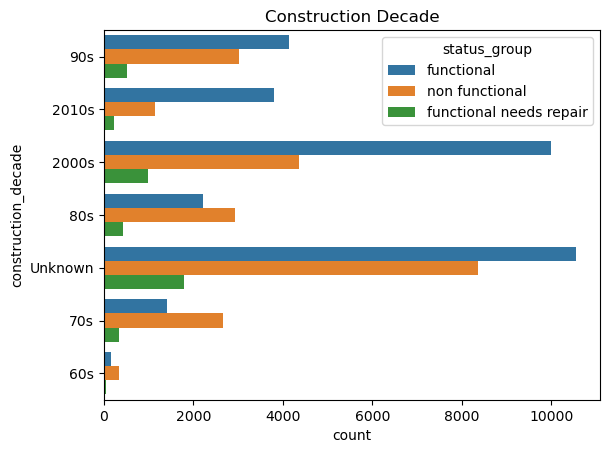

In [36]:
# Author [Jason]

# Function for Region Column Binning. 
# Binning done based on the decade.

def label_construction_year (row):
    if row['construction_year'] in range(1960,1970):
        return "60s"
    if row['construction_year'] in range(1970,1980):
        return "70s"
    if row['construction_year'] in range(1980,1990):
        return "80s"
    if row['construction_year'] in range(1990,2000):
        return "90s"
    if row['construction_year'] in range(2000,2010):
        return "2000s"
    if row['construction_year'] in range(2010, 2020):
        return "2010s"
    return "Unknown"

df['construction_decade'] = df.apply(lambda row: label_construction_year(row), axis=1)

sns.countplot(data=df, y='construction_decade', hue='status_group', dodge=1.0)
plt.title('Construction Decade')
plt.show()

**2.2.3 Region**

Region is binned based on the Tanzania Water and Sanitation Network Website.

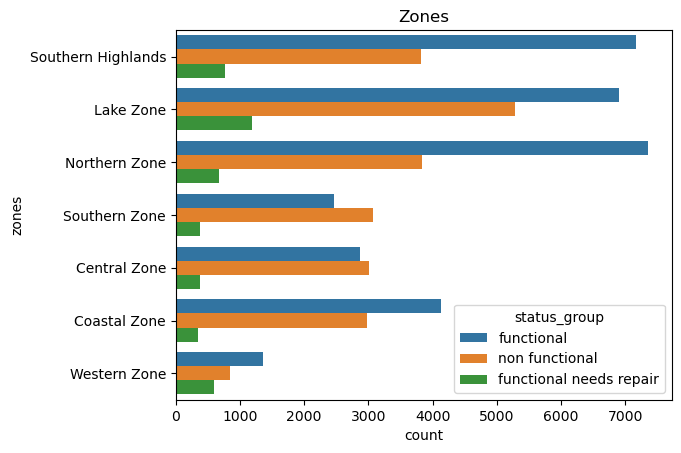

In [37]:
# Author [Jason]

def label_region (row):
    if row['region'] in ['Arusha','Manyara','Kilimanjaro','Tanga']:
        return "Northern Zone"
    if row['region'] in ['Kagera','Mwanza','Shinyanga','Mara']:
        return "Lake Zone"
    if row['region'] in ['Lindi','Ruvuma','Mtwara']:
        return "Southern Zone"
    if row['region'] in ['Rukwa','Mbeya','Iringa']:
        return "Southern Highlands"
    if row['region'] in ['Morogoro','Pwani','Dar es Salaam']:
        return "Coastal Zone"
    if row['region'] in ['Kigoma']:
        return "Western Zone"
    if row['region'] in ['Tabora','Singida','Dodoma']:
        return "Central Zone"
    return "Unknown"

df['zones'] = df.apply(lambda row: label_region(row), axis=1)

sns.countplot(data=df, y='zones', hue='status_group', dodge=1.0)
plt.title('Zones')
plt.show()

### 2.3 Normalisation

In [38]:
# Author [Tom]

def minmax_normalisation(df, col):
    df[col + "_minmaxnormalised"] = ((df[col] - df[col].min()) / (df[col].max() / df[col].min()))
    return df

def zscore_normalisation(df, col):
    df[col + "_zscorenormalise"] = ((df[col] - df[col].mean()) / df[col].std())
    return df

df = minmax_normalisation(df, "gps_height")
df = zscore_normalisation(df, "gps_height")

### 2.4 Feature Encoding

In [39]:
# Author [Jason]

# Function for Target Variable Integer Encoding
def label_outcome (row):
    if row['status_group'] in ['functional']:
        return 0
    if row['status_group'] in ['functional needs repair']:
        return 1
    if row['status_group'] in ['non functional']:
        return 2
    return 999

df['outcome'] = df.apply(lambda row: label_outcome(row), axis=1)

In [40]:
df['permit'] = df['permit'].astype(str)
df['public_meeting'] = df['public_meeting'].astype(str)

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

df = MultiColumnLabelEncoder(columns = ['basin','public_meeting','scheme_management','permit','extraction_type_class',
                                        'management','management_group','payment_type','water_quality','quantity',
                                        'source_type','source_class','waterpoint_type_group','funder_grouped','installer_grouped',
                                        'construction_decade','zones', 'cat_funder', 'cat_installer', 'extraction_type', 'payment',
                                       'waterpoint_type', 'extraction_type_group', 'quality_group','source']).fit_transform(df)

### 2.5 Feature Engineering

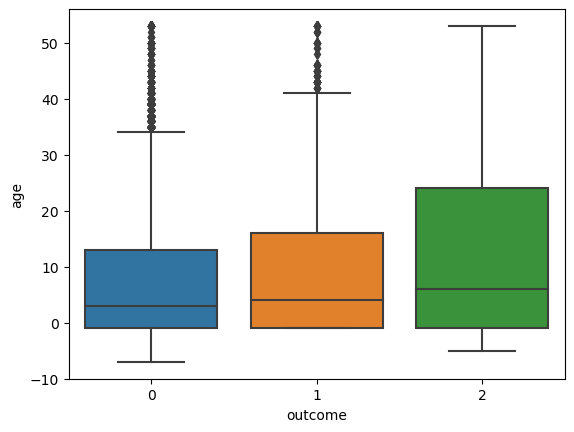

In [41]:
# From here: https://github.com/BrendaLoznik/waterpumps

df['recorded_year'] = pd.DatetimeIndex(df ['date_recorded']).year
df['age'] = df['recorded_year'] - df['construction_year']
df['age'] = df['age'].apply(lambda x: x if x < 100 else -1)
df = df.drop('recorded_year',axis=1)

sns.boxplot(x='outcome', y='age', data=df)
plt.show()

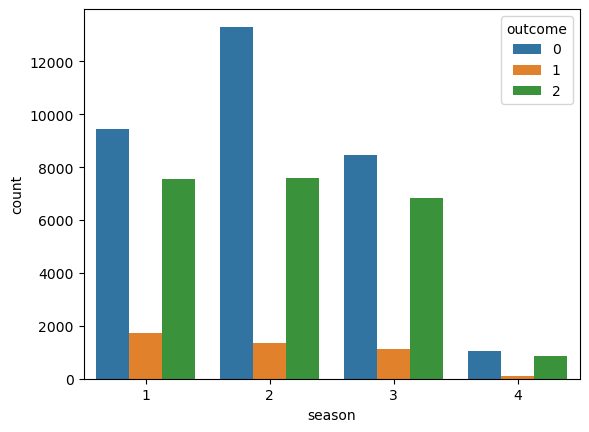

In [42]:
# From here: https://github.com/BrendaLoznik/waterpumps

df['month'] = pd.DatetimeIndex(df['date_recorded']).month

# season encoder
# 1: 'short dry', 2: 'long rain', 3: 'long dry', 4: 'short rain'
season_mapper = {1: 1,2: 1, 3: 2, 4: 2, 5: 2, 6: 3, 7: 3,
                 8: 3, 9: 3, 10: 3, 11: 4, 12: 4}
#.p feature values to scale
df['season']=df['month'].replace(season_mapper)
df=df.drop('month', axis=1)

sns.countplot(x='season', hue='outcome', data=df)
plt.show()

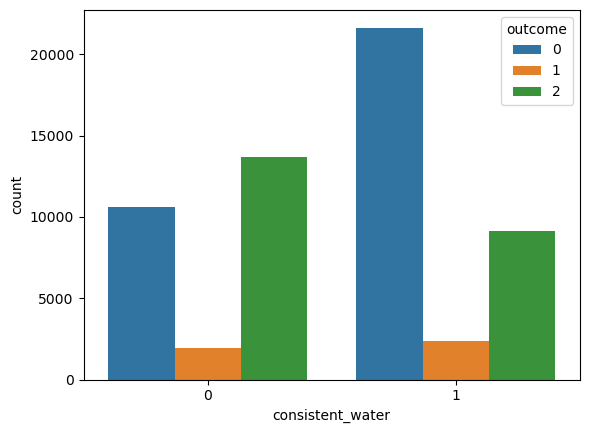

In [43]:
# Author [Tom]

# quantity = 1 (enough) se to 1, everything else set to 0
df['consistent_water'] = np.where(df['quantity'] == 1, 1, 0)

sns.countplot(x='consistent_water', hue='outcome', data=df)
plt.show()

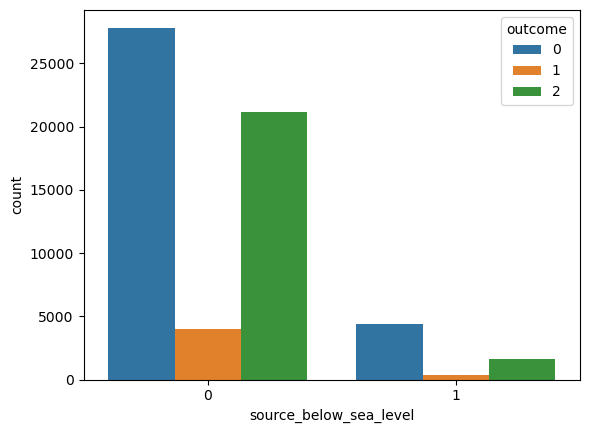

In [44]:
# Author [Tom]

df['source_below_sea_level'] = np.where(df['gps_height'] < df['amount_tsh'], 1, 0)
sns.countplot(x='source_below_sea_level', hue='outcome', data=df)
plt.show()

## 3.0 EDA

In this section, we produce some graphs that we think might be of interest to us.

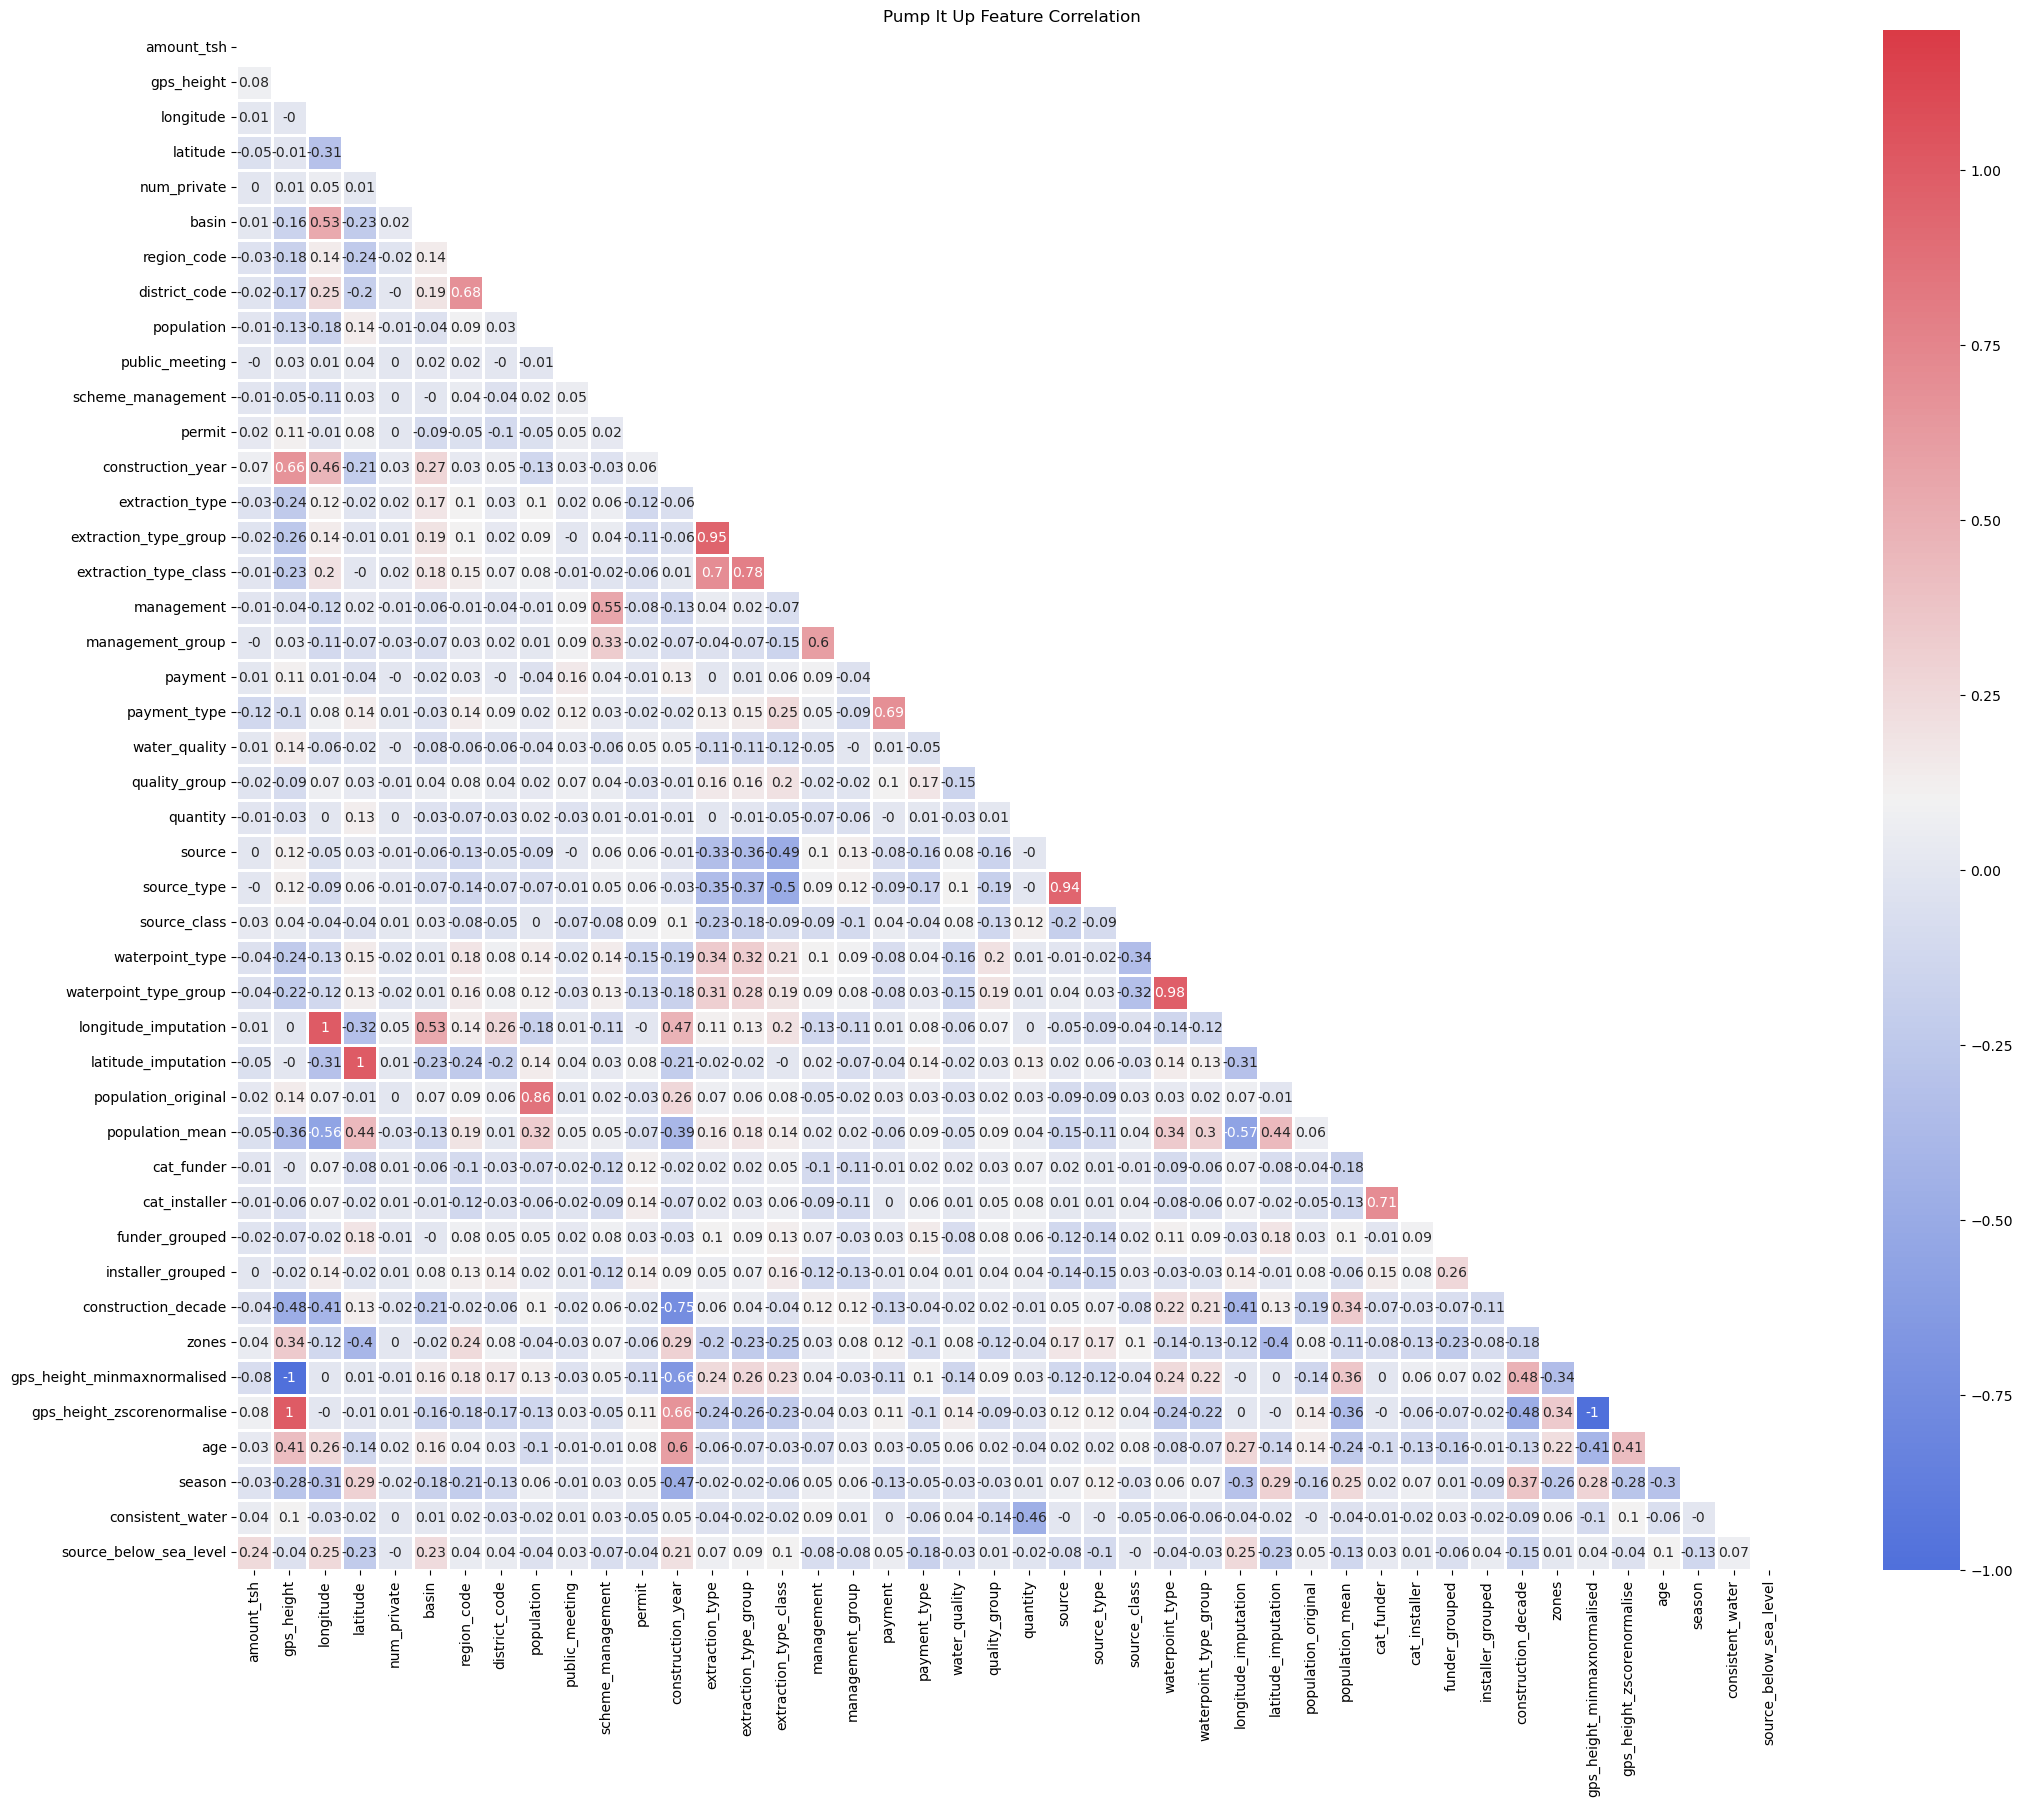

In [45]:
# Author [Jason]
# Code adapted from COMP 3009 Lab Sheet

feature = df.drop(columns=['id','outcome'])

corrMatt = feature.corr().round(2)

# Generate a mask for the upper triangle
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(25, 20))
plt.title('Pump It Up Feature Correlation')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatt, vmax=1.2, square=False, cmap=cmap, mask=mask,
ax=ax, annot=True, fmt='.2g', linewidths=1);

There's not many super highly correlated features

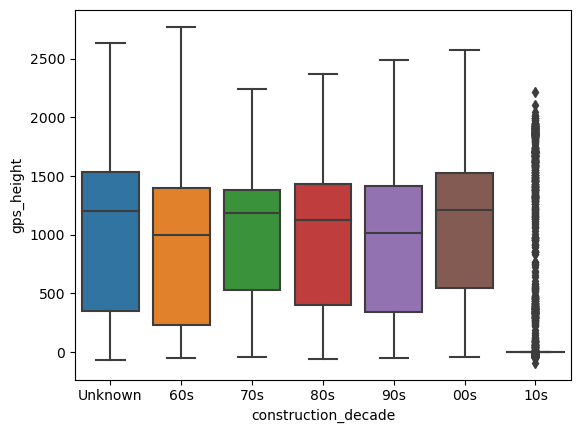

In [46]:
ax = sns.boxplot(data=df, x='construction_decade', y='gps_height')
ax.set_xticklabels(['Unknown', '60s', '70s', '80s', '90s', '00s', '10s'])
plt.show()

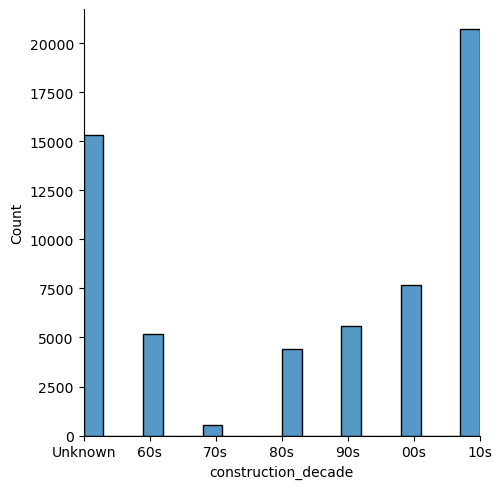

In [47]:
ax = sns.displot(data=df, x='construction_decade')
plt.xlim(0,6)
ax.set_xticklabels(['Unknown', '60s', '70s', '80s', '90s', '00s', '10s'])
plt.show()

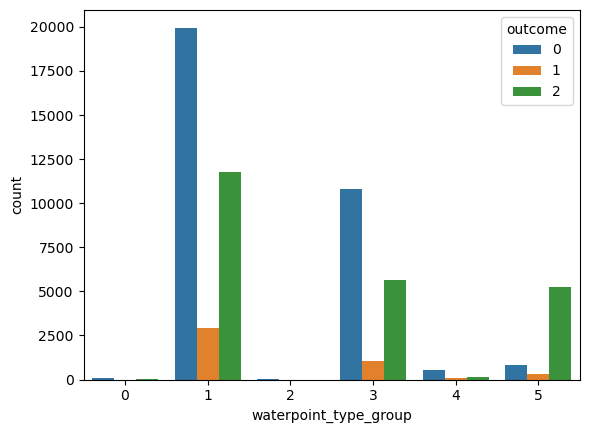

In [48]:
sns.countplot(x='waterpoint_type_group', hue='outcome', data=df)
plt.show()

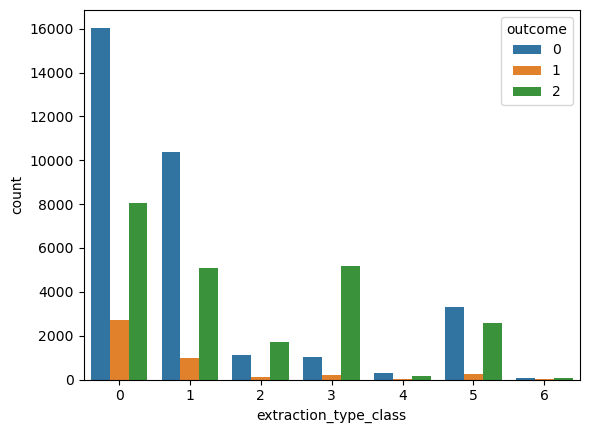

In [49]:
sns.countplot(x='extraction_type_class', hue='outcome', data=df)
plt.show()

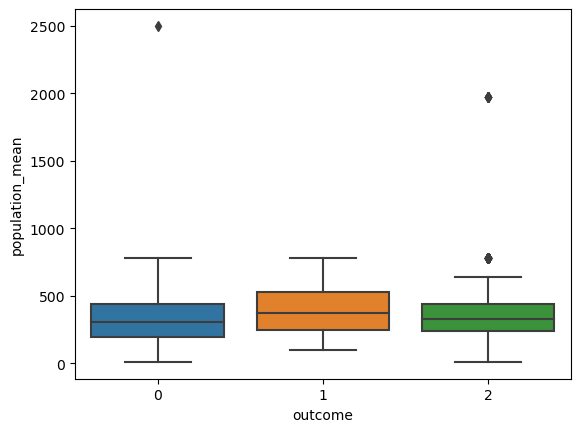

In [50]:
sns.boxplot(x='outcome', y='population_mean', data=df)
plt.show()

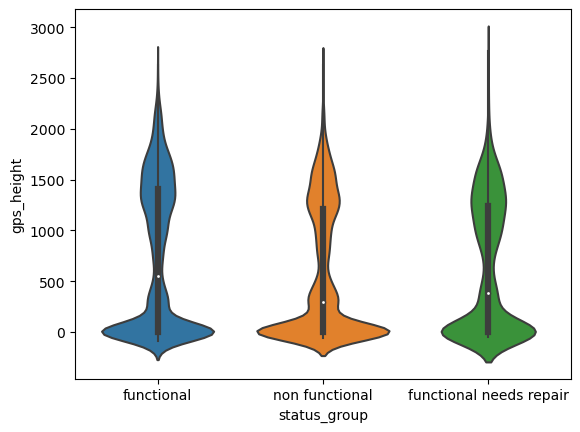

In [51]:
sns.violinplot(x='status_group', y='gps_height', data=df)
plt.show()

# 4.0 Modelling

This section details all the steps we took to build our final models, including feature importance and hyper-parameter tuning.

### 4.1 Feature Importance

**4.1.1 RandomForest**

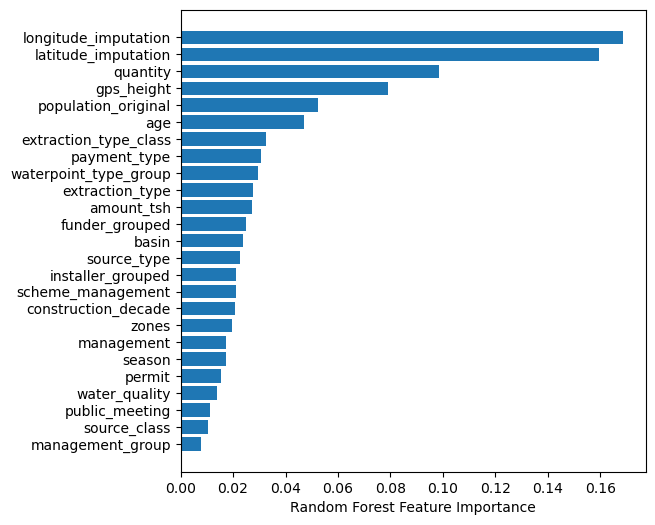

In [52]:
# Author [Jason]
classification_target = df['outcome']

clean_feature = feature.drop(columns = ['date_recorded', 'wpt_name','num_private','subvillage','region_code','district_code','lga','ward','recorded_by',
                            'scheme_name','extraction_type_group','payment','quality_group','quantity_group',
                            'source','waterpoint_type','status_group','construction_year','region','funder','installer',
                            'installer_clean', 'funder_clean','longitude','latitude','gps_height_minmaxnormalised','gps_height_zscorenormalise','population',
                            'population_mean','cat_funder','cat_installer','consistent_water','source_below_sea_level'])

X_train, X_test, y_train, y_test = train_test_split(clean_feature,classification_target, test_size=0.2, random_state=42, stratify=classification_target)
rf = RandomForestClassifier(n_estimators=64, class_weight="balanced", criterion= 'gini', max_features= 'auto')
rf.fit(X_train, y_train)

sorted_idx = rf.feature_importances_.argsort()
plt.figure(figsize=(6,6))
plt.barh(clean_feature.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()

**4.1.2 Chi-Squared Test**

In [53]:
# Author [Jason]
classification_target = df['outcome']
categorical_features = df[['basin','public_meeting','scheme_management','permit','extraction_type_class','management','management_group','payment_type','water_quality','quantity','source_type',
                           'source_class','waterpoint_type_group','funder_grouped','installer_grouped','construction_decade','zones']]

# Select the top 10 best categorical features
categorical_features = SelectKBest(chi2, k=10).fit(categorical_features, classification_target)

# Convert the selected clinical feature's header name into a list
categorical_features_list = list(categorical_features.get_feature_names_out())
print(categorical_features_list)

['basin', 'extraction_type_class', 'management', 'payment_type', 'quantity', 'source_type', 'source_class', 'waterpoint_type_group', 'construction_decade', 'zones']


**4.1.3 XGBoost**

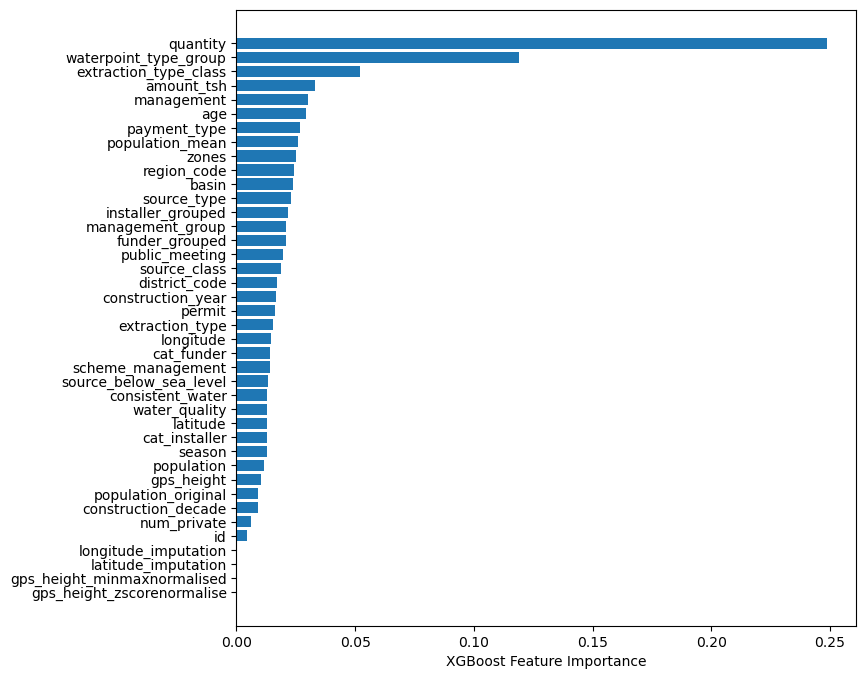

In [53]:
# Author [Tom]

features = df.drop(['outcome', 'funder', 'installer',
                    'wpt_name', 'subvillage', 'region',
                    'lga', 'ward', 'recorded_by', 'scheme_name',
                    'extraction_type_group', 'payment', 'quality_group',
                    'quantity_group', 'source', 'waterpoint_type',
                    'status_group', 'date_recorded', 'funder_clean', 'installer_clean'], axis=1)
target = df['outcome']

feature_names = features.columns
clf_xgb = xgb.XGBClassifier(random_state=42)
clf_xgb.fit(features, target)

sorted_idx = clf_xgb.feature_importances_.argsort()
plt.figure(figsize=(8,8))
plt.barh(features.columns[sorted_idx], clf_xgb.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance")
plt.show()

### 4.2 Tom's Modelling

All cells in this section were written by Tom.

**4.2.1 Splitting into Test/Train**

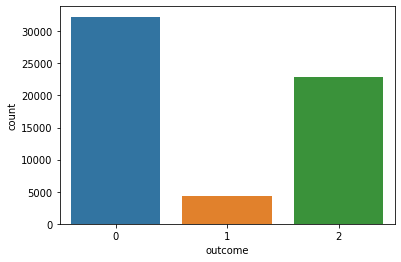

In [32]:
# These were not the original choice, these were retro-actively changed from feature selection testing on WandB
# As well as other tests we ran.

features = df[['age', 'latitude_imputation', 'longitude_imputation', 'construction_decade',
               'quality_group', 'basin', 'extraction_type', 'cat_installer', 'population',
               'gps_height_zscorenormalise', 'cat_funder', 'quantity', 'consistent_water',
               'source_class', 'zones', 'waterpoint_type', 'season', 'extraction_type_class',
               'payment']]
target = df['outcome']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

sns.countplot(x='outcome', data=df)
plt.show()

**4.2.2 Model Overview**

In [106]:
init_features = df.drop(['id', 'date_recorded', 'funder', 'installer', 
                        'wpt_name', 'subvillage', 'region', 'lga', 'ward',
                        'recorded_by', 'scheme_name', 'quantity_group',
                        'status_group', 'funder_clean', 'installer_clean', 'outcome'
                        ], axis=1)
init_target = df['outcome']

init_X_train, init_X_test, init_y_train, init_y_test = train_test_split(init_features,
                                                                        init_target, test_size=0.2,
                                                                        random_state=42, stratify=init_target)

models = [
    HistGradientBoostingClassifier(random_state=42),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=42),
    xgb.XGBClassifier(random_state=42),
    BaggingClassifier(random_state=42),
    CatBoostClassifier(random_state=42, verbose=0)
]

names = ['HistGradientBoosting', 'KNN', 'DT', 'XGB',
         'Bagging', 'CatBoost']

acc = []
prec = []
rec = []

for model in models:
    model.fit(init_X_train, init_y_train)
    preds = model.predict(init_X_test)
    
    acc.append(accuracy_score(init_y_test, preds))
    prec.append(precision_score(init_y_test, preds, average="macro"))
    rec.append(recall_score(init_y_test, preds, average="macro"))

model_df = pd.DataFrame({'Model': names, 'Acc': acc, 'Precision': prec, 'Recall': rec})
model_df.sort_values('Acc', ascending=False)

,Model,Acc,Precision,Recall
3,XGB,0.796465,0.746989,0.630674
5,CatBoost,0.793519,0.740989,0.630154
4,Bagging,0.792508,0.699592,0.654358
0,HistGradientBoosting,0.790236,0.750804,0.625876
2,DT,0.756650,0.646476,0.648737
1,KNN,0.708670,0.622806,0.563406


**4.2.3 Cross-Validation Accuracy on different models**

In [107]:
def run_classifier(clf, X, y,  X_test, y_test):
    scores = cross_val_score(clf, X, y, cv=5)
    print("Cross-Val")
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    print("--------------------------------------")
    clf.fit(X, y)
    preds = clf.predict(X_test)
    print("1 fit")
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds, average='macro'))
    print("Recall:", recall_score(y_test, preds, average='macro'))
    print("F1 Score:", f1_score(y_test, preds, average='macro'))
    cmap = sns.diverging_palette(260, 10, as_cmap=True)
    sns.heatmap(confusion_matrix(y_test, preds), cmap=cmap, annot=True)
    plt.show()

HGBoost
Cross-Val
0.79 accuracy with a standard deviation of 0.00
--------------------------------------
1 fit
Accuracy: 0.7888047138047138
Precision: 0.7422443042128806
Recall: 0.619580004916994
F1 Score: 0.6473069247547721


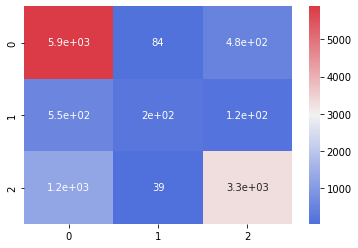

In [111]:
clf_hgb = HistGradientBoostingClassifier(random_state=42)
print("HGBoost")
run_classifier(clf_hgb, X_train, y_train, X_test, y_test)

XGBoost
Cross-Val
0.79 accuracy with a standard deviation of 0.00
--------------------------------------
1 fit
Accuracy: 0.7937710437710438
Precision: 0.7545982155192178
Recall: 0.6239237515590169
F1 Score: 0.6524833931201058


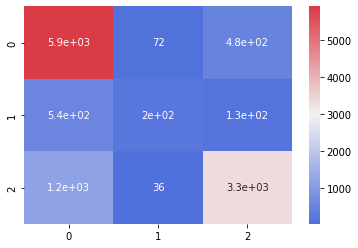

In [112]:
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'merror',
    'seed': 0
}
clf_xgb = xgb.XGBClassifier(**params)
print("XGBoost")
run_classifier(clf_xgb, X_train, y_train, X_test, y_test)

Accuracy: 0.7346801346801347
Precision: 0.6486724846405904
Recall: 0.7206217911933429


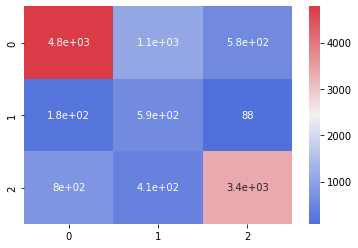

In [113]:
sample_weights = compute_sample_weight(class_weight='balanced',y=y_train)
clf_xgb = xgb.XGBClassifier(**params)
# We are using 'class_weight' == 'balanced' here, which results in improved recall, worse accuracy.
clf_xgb.fit(X_train, y_train, sample_weight=sample_weights)
preds = clf_xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, preds))
print("Precision:", precision_score(y_test, preds, average='macro'))
print("Recall:", recall_score(y_test, preds, average='macro'))
cmap = sns.diverging_palette(260, 10, as_cmap=True)
sns.heatmap(confusion_matrix(y_test, preds), cmap=cmap, annot=True)
plt.show()

CatBoost
Cross-Val
0.73 accuracy with a standard deviation of 0.00
--------------------------------------
1 fit
Accuracy: 0.7265151515151516
Precision: 0.6427561477969254
Recall: 0.7178457479446078
F1 Score: 0.6485658415277004


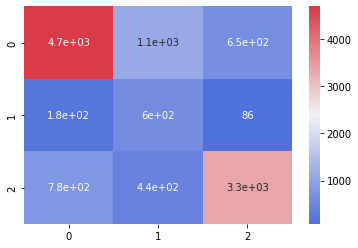

In [114]:
clf_cb = CatBoostClassifier(random_state=42, verbose=0, auto_class_weights="Balanced")
print("CatBoost")
run_classifier(clf_cb, X_train, y_train, X_test, y_test)

Bagging
Cross-Val
0.78 accuracy with a standard deviation of 0.00
--------------------------------------
1 fit
Accuracy: 0.7930134680134681
Precision: 0.7010528147303227
Recall: 0.6585474845647888
F1 Score: 0.6749133205669945


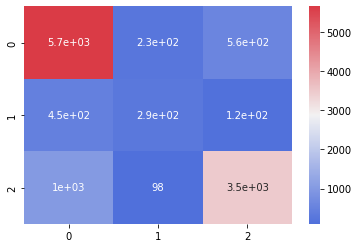

In [115]:
clf_bagging = BaggingClassifier(random_state=42)
print("Bagging")
run_classifier(clf_bagging, X_train, y_train, X_test, y_test)

**4.2.4 Balancing the Dataset**

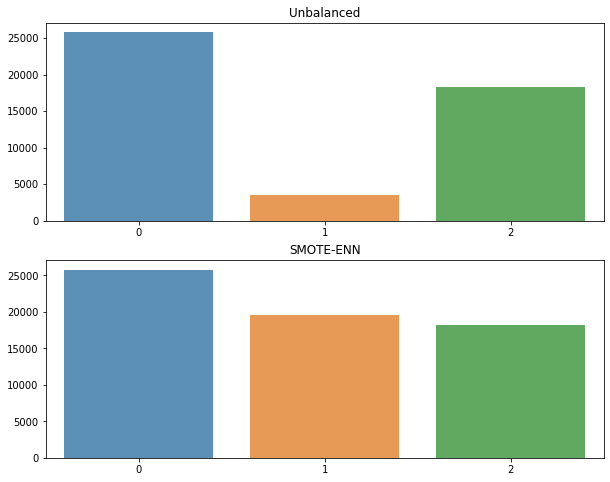

In [122]:
sm = SMOTE(random_state=42, k_neighbors=12, sampling_strategy='minority')
enn = EditedNearestNeighbours(sampling_strategy=[1])
sme = SMOTEENN(random_state=42, smote=sm, enn=enn)
X_res, y_res = sme.fit_resample(X_train, y_train)
y_train_count = y_train.value_counts()

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

sns.barplot(x=y_train_count.index, y=y_train_count.values, alpha=0.8, ax=axs[0])
axs[0].set_title("Unbalanced")
y_res_count = y_res.value_counts()
sns.barplot(x=y_res_count.index, y=y_res_count.values, alpha=0.8, ax=axs[1])
axs[1].set_title("SMOTE-ENN")
plt.show()

**4.2.5 Cross-Validation on the Balanced Dataset**

XGBoost
Cross-Val
0.83 accuracy with a standard deviation of 0.03
--------------------------------------
1 fit
Accuracy: 0.7783670033670034
Precision: 0.6781303537671827
Recall: 0.664842342879783
F1 Score: 0.6689510733578446


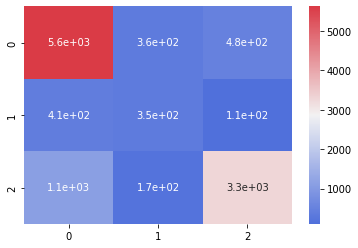

In [123]:
clf_xgb = xgb.XGBClassifier(random_state=42)
print("XGBoost")
run_classifier(clf_xgb, X_res, y_res, X_test, y_test)

CatBoost
Cross-Val
0.82 accuracy with a standard deviation of 0.03
--------------------------------------
1 fit
Accuracy: 0.7675925925925926
Precision: 0.6589085160109432
Recall: 0.6792227178752993
F1 Score: 0.6668707253711559


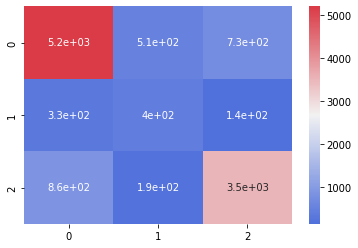

In [124]:
clf_cb = CatBoostClassifier(random_state=42, verbose=0, auto_class_weights="Balanced")
print("CatBoost")
run_classifier(clf_cb, X_res, y_res, X_test, y_test)

HGBoost
Cross-Val
0.82 accuracy with a standard deviation of 0.03
--------------------------------------
1 fit
Accuracy: 0.7732323232323233
Precision: 0.6726537467465724
Recall: 0.6640401095732611
F1 Score: 0.6655719034184779


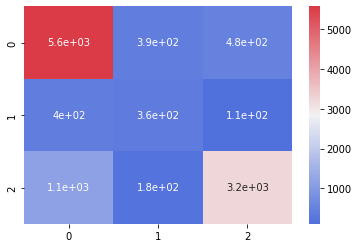

In [126]:
clf_hgb = HistGradientBoostingClassifier(random_state=42)
print("HGBoost")
run_classifier(clf_hgb, X_res, y_res, X_test, y_test)

Bagging
Cross-Val
0.84 accuracy with a standard deviation of 0.02
--------------------------------------
1 fit
Accuracy: 0.784006734006734
Precision: 0.6767851094009422
Recall: 0.646648136691048
F1 Score: 0.6587420479388814


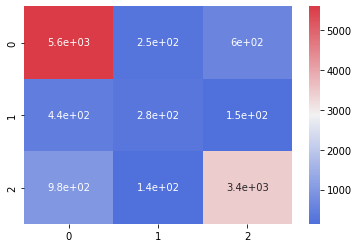

In [127]:
clf_bagging = BaggingClassifier(random_state=42)
print("Bagging")
run_classifier(clf_bagging, X_res, y_res, X_test, y_test)

**4.2.6 Hyper-Parameter Searching**

I will be performing hyper-parameter tuning on both the balanced and unbalanced dataset to compare performance. I will also be comparing tuning for `recall_macro` and `accuracy`.

**⚠️ These cells could take a long time to run ⚠️**

The order of tuning is:

    - Tune for 'recall_macro'
        - On Balanced Dataset
        - On UnBalanced Dataset
    - Tune for 'accuracy'
        - On Balanced Dataset
        - On UnBalanced Dataset

In [129]:
def display_results(rcv):
    print("Best Params:", rcv.best_params_)
    print("Best Estiamtor:", rcv.best_estimator_)
    print("Best Score:", rcv.best_score_)
    
    preds = rcv.best_estimator_.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds, average='macro'))
    print("Recall:", recall_score(y_test, preds, average='macro'))
    print("F1 Score:", f1_score(y_test, preds, average='macro'))

    print(classification_report(y_test, preds))

    cmap = sns.diverging_palette(260, 10, as_cmap=True)
    sns.heatmap(confusion_matrix(y_test, preds), cmap=cmap, annot=True)
    plt.show()

def run_random_cv(estimator, hps, scoring, X, y):
    random_cv = RandomizedSearchCV(estimator=estimator,
                                   param_distributions=hps,
                                   cv=3, n_iter=25,
                                   scoring=scoring,
                                   verbose=1,
                                   return_train_score=True,
                                   random_state=42)
    random_cv.fit(X, y)
    print("-----------------------------------------")
    print("Best Params:", random_cv.best_params_)
    print("Best Score:", random_cv.best_score_)
    print("-----------------------------------------")
    preds = random_cv.best_estimator_.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds, average='macro'))
    print("Recall:", recall_score(y_test, preds, average='macro'))
    print("F1 Score:", f1_score(y_test, preds, average='macro'))

    print(classification_report(y_test, preds))

    cmap = sns.diverging_palette(260, 10, as_cmap=True)
    sns.heatmap(confusion_matrix(y_test, preds), cmap=cmap, annot=True)
    plt.show()

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'subsample': 0.8, 'reg_lambda': 1e-05, 'reg_alpha': 1, 'random_state': 42, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 1}
Best Score: 0.8505498708196653
-----------------------------------------
Accuracy: 0.8003367003367003
Precision: 0.70026819486161
Recall: 0.6615685577237601
F1 Score: 0.6765898222956613
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      6452
           1       0.45      0.33      0.38       863
           2       0.84      0.78      0.81      4565

    accuracy                           0.80     11880
   macro avg       0.70      0.66      0.68     11880
weighted avg       0.79      0.80      0.80     11880



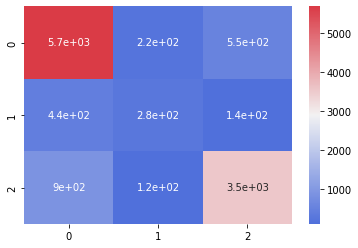

In [131]:
xgb_hps = {
        'max_depth': [3, 6, 9],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0, 1e-5, 1e-3, 1e-1, 1,1e2],
        'reg_lambda': [0, 1e-5, 1e-3, 1e-1, 1, 1e2],
        'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.3],
        'n_estimators': [50, 100, 150, 200],
        'min_child_weight': [0, 0.2, 0.4, 0.6, 0.8, 1],
        'subsample': [0.8, 1],
        'colsample_bytree': [0.5, 0.7, 0.9, 1],
        'random_state': [42]
}
clf_xgb = xgb.XGBClassifier()
run_random_cv(estimator=clf_xgb, hps=xgb_hps, scoring='recall_macro', X=X_res, y=y_res)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'verbose': 0, 'random_strength': 10, 'random_state': 42, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'iterations': 1000, 'grow_policy': 'Depthwise', 'depth': 8, 'border_count': 32, 'bagging_temperature': 1.0}
Best Score: 0.8372818923856752
-----------------------------------------
Accuracy: 0.7814814814814814
Precision: 0.6681944451432904
Recall: 0.658332141178885
F1 Score: 0.6625956893733628
              precision    recall  f1-score   support

           0       0.80      0.85      0.83      6452
           1       0.38      0.36      0.37       863
           2       0.82      0.76      0.79      4565

    accuracy                           0.78     11880
   macro avg       0.67      0.66      0.66     11880
weighted avg       0.78      0.78      0.78     11880



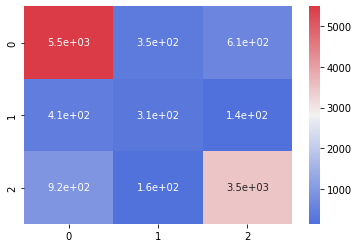

In [133]:
cb_hps = {
    'iterations': [100, 500, 1000],
    'learning_rate': [0.03, 0.1, 0.3],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0.0, 0.5, 1.0],
    'random_strength':[0, 1, 5, 10],
    'border_count': [32, 64, 128],
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
    'verbose': [0],
    'random_state': [42]
}
clf_cb = CatBoostClassifier()
run_random_cv(estimator=clf_cb, hps=cb_hps, scoring='recall_macro', X=X_res, y=y_res)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'validation_fraction': 0.1, 'random_state': 42, 'n_iter_no_change': 5, 'min_samples_leaf': 5, 'max_leaf_nodes': None, 'max_iter': 750, 'max_depth': 8, 'max_bins': 255, 'learning_rate': 0.05, 'l2_regularization': 1.0, 'early_stopping': False}
Best Score: 0.8486407870644846
-----------------------------------------
Accuracy: 0.7974747474747474
Precision: 0.6989443973682609
Recall: 0.666482395711279
F1 Score: 0.6796577150686406
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      6452
           1       0.45      0.35      0.40       863
           2       0.85      0.77      0.80      4565

    accuracy                           0.80     11880
   macro avg       0.70      0.67      0.68     11880
weighted avg       0.79      0.80      0.79     11880



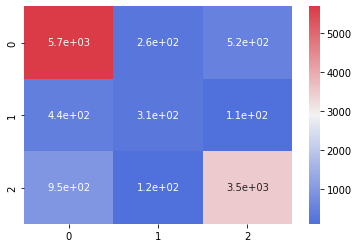

In [132]:
hgb_hps = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [250, 750],
    'max_depth': [2, 4, 6, 8],
    'min_samples_leaf': [1, 5, 10],
    'max_leaf_nodes': [None, 4, 8, 12],
    'l2_regularization': [0.0, 0.1, 0.5, 1.0],
    'max_bins': [64, 128, 255],
    'early_stopping': [False, 'auto'],
    'validation_fraction': [0.1, 0.2],
    'n_iter_no_change': [5, 10, 20],
    'random_state': [42]
}
clf_hgb = HistGradientBoostingClassifier()
run_random_cv(estimator=clf_hgb, hps=hgb_hps, scoring='recall_macro', X=X_res, y=y_res)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'warm_start': True, 'random_state': 42, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap_features': True, 'bootstrap': True}
Best Score: 0.8519065189924703
-----------------------------------------
Accuracy: 0.8005050505050505
Precision: 0.7014810943553019
Recall: 0.6711826753677173
F1 Score: 0.6837066500350705
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      6452
           1       0.45      0.36      0.40       863
           2       0.84      0.77      0.81      4565

    accuracy                           0.80     11880
   macro avg       0.70      0.67      0.68     11880
weighted avg       0.80      0.80      0.80     11880



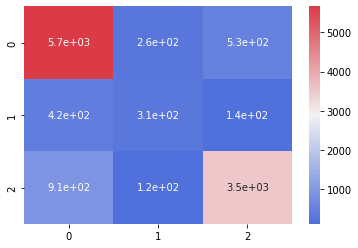

In [141]:
bc_hps = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 1.0],
    'max_features': [0.5, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'warm_start': [True, False],
    'n_jobs': [-1],
    'random_state': [42]
}
clf_bc = BaggingClassifier()
run_random_cv(estimator=clf_bc, hps=bc_hps, scoring='recall_macro', X=X_res, y=y_res)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'subsample': 0.8, 'reg_lambda': 1e-05, 'reg_alpha': 1, 'random_state': 42, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 1}
Best Score: 0.6567268623021651
-----------------------------------------
Accuracy: 0.8015151515151515
Precision: 0.7155433045345788
Recall: 0.6589032765897925
F1 Score: 0.6788050032686156
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      6452
           1       0.51      0.32      0.39       863
           2       0.84      0.78      0.80      4565

    accuracy                           0.80     11880
   macro avg       0.72      0.66      0.68     11880
weighted avg       0.79      0.80      0.79     11880



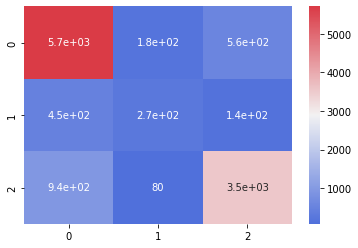

In [137]:
run_random_cv(estimator=clf_xgb, hps=xgb_hps, scoring='recall_macro', X=X_train, y=y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'verbose': 0, 'random_strength': 5, 'random_state': 42, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'iterations': 500, 'grow_policy': 'Depthwise', 'depth': 6, 'border_count': 64, 'bagging_temperature': 0.5}
Best Score: 0.6502541871104993
-----------------------------------------
Accuracy: 0.8014309764309764
Precision: 0.7325694679873368
Recall: 0.6521812858365813
F1 Score: 0.6769529204427666
              precision    recall  f1-score   support

           0       0.80      0.89      0.84      6452
           1       0.57      0.30      0.39       863
           2       0.84      0.77      0.80      4565

    accuracy                           0.80     11880
   macro avg       0.73      0.65      0.68     11880
weighted avg       0.79      0.80      0.79     11880



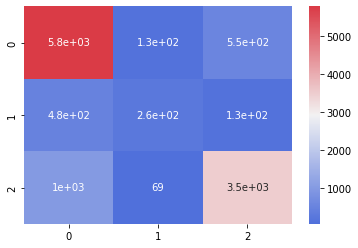

In [138]:
run_random_cv(estimator=clf_cb, hps=cb_hps, scoring='recall_macro', X=X_train, y=y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'validation_fraction': 0.1, 'random_state': 42, 'n_iter_no_change': 5, 'min_samples_leaf': 5, 'max_leaf_nodes': None, 'max_iter': 750, 'max_depth': 8, 'max_bins': 255, 'learning_rate': 0.05, 'l2_regularization': 1.0, 'early_stopping': False}
Best Score: 0.6552691782533954
-----------------------------------------
Accuracy: 0.8064814814814815
Precision: 0.7330317000271162
Recall: 0.662008387801858
F1 Score: 0.6855067864355195
              precision    recall  f1-score   support

           0       0.80      0.90      0.85      6452
           1       0.55      0.32      0.40       863
           2       0.84      0.77      0.81      4565

    accuracy                           0.81     11880
   macro avg       0.73      0.66      0.69     11880
weighted avg       0.80      0.81      0.80     11880



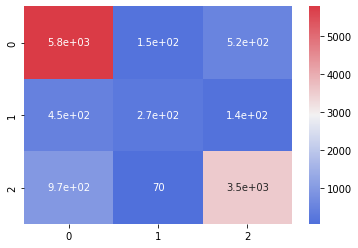

In [139]:
run_random_cv(estimator=clf_hgb, hps=hgb_hps, scoring='recall_macro', X=X_train, y=y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'warm_start': True, 'random_state': 42, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 0.5, 'max_features': 1.0, 'bootstrap_features': False, 'bootstrap': False}
Best Score: 0.656109300825305
-----------------------------------------
Accuracy: 0.8028619528619528
Precision: 0.7201200258496477
Recall: 0.6592529238082403
F1 Score: 0.6801265210820514
              precision    recall  f1-score   support

           0       0.80      0.89      0.84      6452
           1       0.52      0.31      0.39       863
           2       0.83      0.78      0.81      4565

    accuracy                           0.80     11880
   macro avg       0.72      0.66      0.68     11880
weighted avg       0.80      0.80      0.80     11880



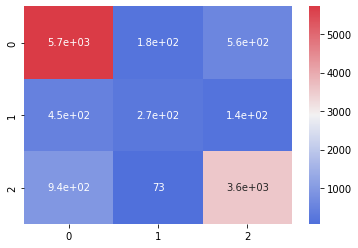

In [142]:
run_random_cv(estimator=clf_bc, hps=bc_hps, scoring='recall_macro', X=X_train, y=y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'subsample': 0.8, 'reg_lambda': 1e-05, 'reg_alpha': 1, 'random_state': 42, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 1}
Best Score: 0.8532964462857139
-----------------------------------------
Accuracy: 0.8003367003367003
Precision: 0.70026819486161
Recall: 0.6615685577237601
F1 Score: 0.6765898222956613
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      6452
           1       0.45      0.33      0.38       863
           2       0.84      0.78      0.81      4565

    accuracy                           0.80     11880
   macro avg       0.70      0.66      0.68     11880
weighted avg       0.79      0.80      0.80     11880



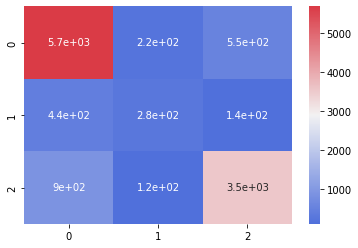

In [143]:
run_random_cv(estimator=clf_xgb, hps=xgb_hps, scoring='accuracy', X=X_res, y=y_res)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'verbose': 0, 'random_strength': 0, 'random_state': 42, 'learning_rate': 0.3, 'l2_leaf_reg': 3, 'iterations': 1000, 'grow_policy': 'Depthwise', 'depth': 6, 'border_count': 32, 'bagging_temperature': 0.0}
Best Score: 0.8396593998492027
-----------------------------------------
Accuracy: 0.7872053872053872
Precision: 0.6780292428252971
Recall: 0.6649491030301271
F1 Score: 0.6703359629902672
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      6452
           1       0.39      0.37      0.38       863
           2       0.84      0.76      0.80      4565

    accuracy                           0.79     11880
   macro avg       0.68      0.66      0.67     11880
weighted avg       0.79      0.79      0.79     11880



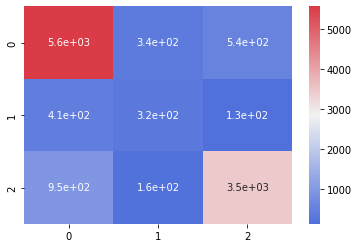

In [144]:
run_random_cv(estimator=clf_cb, hps=cb_hps, scoring='accuracy', X=X_res, y=y_res)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'validation_fraction': 0.1, 'random_state': 42, 'n_iter_no_change': 5, 'min_samples_leaf': 5, 'max_leaf_nodes': None, 'max_iter': 750, 'max_depth': 8, 'max_bins': 255, 'learning_rate': 0.05, 'l2_regularization': 1.0, 'early_stopping': False}
Best Score: 0.8521639248997381
-----------------------------------------
Accuracy: 0.7974747474747474
Precision: 0.6989443973682609
Recall: 0.666482395711279
F1 Score: 0.6796577150686406
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      6452
           1       0.45      0.35      0.40       863
           2       0.85      0.77      0.80      4565

    accuracy                           0.80     11880
   macro avg       0.70      0.67      0.68     11880
weighted avg       0.79      0.80      0.79     11880



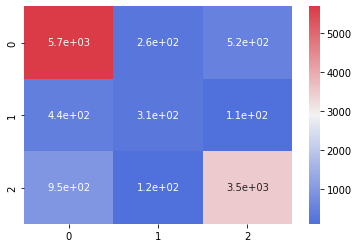

In [145]:
run_random_cv(estimator=clf_hgb, hps=hgb_hps, scoring='accuracy', X=X_res, y=y_res)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'warm_start': True, 'random_state': 42, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap_features': True, 'bootstrap': True}
Best Score: 0.8548534907253215
-----------------------------------------
Accuracy: 0.8005050505050505
Precision: 0.7014810943553019
Recall: 0.6711826753677173
F1 Score: 0.6837066500350705
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      6452
           1       0.45      0.36      0.40       863
           2       0.84      0.77      0.81      4565

    accuracy                           0.80     11880
   macro avg       0.70      0.67      0.68     11880
weighted avg       0.80      0.80      0.80     11880



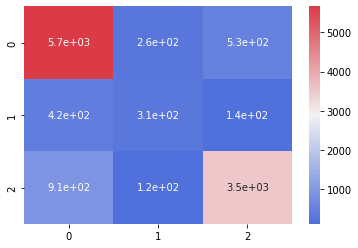

In [146]:
run_random_cv(estimator=clf_bc, hps=bc_hps, scoring='accuracy', X=X_res, y=y_res)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'subsample': 0.8, 'reg_lambda': 1e-05, 'reg_alpha': 1, 'random_state': 42, 'n_estimators': 150, 'min_child_weight': 0.8, 'max_depth': 9, 'learning_rate': 0.15, 'gamma': 0.1, 'colsample_bytree': 0.5}
Best Score: 0.7970538720538721
-----------------------------------------
Accuracy: 0.8042929292929293
Precision: 0.7481296879006885
Recall: 0.6484207682571453
F1 Score: 0.6762875111787156
              precision    recall  f1-score   support

           0       0.79      0.91      0.84      6452
           1       0.60      0.28      0.38       863
           2       0.85      0.76      0.80      4565

    accuracy                           0.80     11880
   macro avg       0.75      0.65      0.68     11880
weighted avg       0.80      0.80      0.79     11880



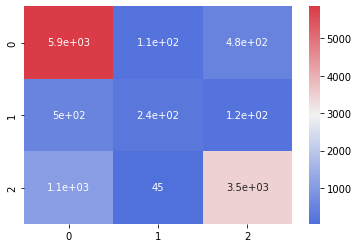

In [147]:
run_random_cv(estimator=clf_xgb, hps=xgb_hps, scoring='accuracy', X=X_train, y=y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'verbose': 0, 'random_strength': 1, 'random_state': 42, 'learning_rate': 0.03, 'l2_leaf_reg': 5, 'iterations': 1000, 'grow_policy': 'Depthwise', 'depth': 8, 'border_count': 32, 'bagging_temperature': 0.5}
Best Score: 0.7927398989898989
-----------------------------------------
Accuracy: 0.7968855218855219
Precision: 0.7531788952921598
Recall: 0.635901308370895
F1 Score: 0.6649898809323646
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      6452
           1       0.64      0.26      0.37       863
           2       0.84      0.74      0.79      4565

    accuracy                           0.80     11880
   macro avg       0.75      0.64      0.66     11880
weighted avg       0.79      0.80      0.79     11880



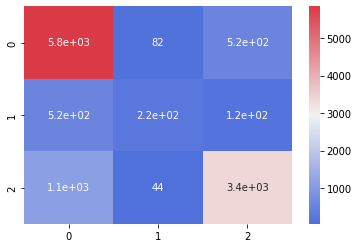

In [148]:
run_random_cv(estimator=clf_cb, hps=cb_hps, scoring='accuracy', X=X_train, y=y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'validation_fraction': 0.1, 'random_state': 42, 'n_iter_no_change': 5, 'min_samples_leaf': 5, 'max_leaf_nodes': None, 'max_iter': 750, 'max_depth': 8, 'max_bins': 255, 'learning_rate': 0.05, 'l2_regularization': 1.0, 'early_stopping': False}
Best Score: 0.7930134680134681
-----------------------------------------
Accuracy: 0.8064814814814815
Precision: 0.7330317000271162
Recall: 0.662008387801858
F1 Score: 0.6855067864355195
              precision    recall  f1-score   support

           0       0.80      0.90      0.85      6452
           1       0.55      0.32      0.40       863
           2       0.84      0.77      0.81      4565

    accuracy                           0.81     11880
   macro avg       0.73      0.66      0.69     11880
weighted avg       0.80      0.81      0.80     11880



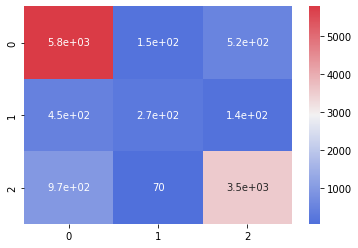

In [149]:
run_random_cv(estimator=clf_hgb, hps=hgb_hps, scoring='accuracy', X=X_train, y=y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'warm_start': True, 'random_state': 42, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 0.5, 'max_features': 1.0, 'bootstrap_features': True, 'bootstrap': False}
Best Score: 0.7998947811447811
-----------------------------------------
Accuracy: 0.8111111111111111
Precision: 0.7411583251485916
Recall: 0.6560438343165815
F1 Score: 0.6810450375448204
              precision    recall  f1-score   support

           0       0.80      0.90      0.85      6452
           1       0.57      0.28      0.38       863
           2       0.85      0.78      0.81      4565

    accuracy                           0.81     11880
   macro avg       0.74      0.66      0.68     11880
weighted avg       0.80      0.81      0.80     11880



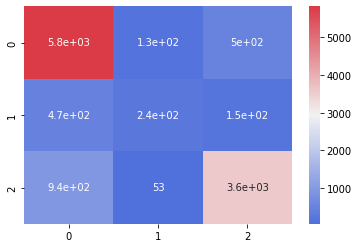

In [150]:
run_random_cv(estimator=clf_bc, hps=bc_hps, scoring='accuracy', X=X_train, y=y_train)

**4.2.7 Testing Features / Hyperparameters with Weights & Biases**

We know have lists of possible features and hyper-parameters. We can run some tests with different combinations of them on Weights and Biases to see which combination is the best. 

*To run this, you may need access to our Weights and Biases team. If you want access to it please email me at thomascotter00@gmail.com*

In [134]:
# This current set-up doesn't balanced the dataset, as I found there was not much need for it.

def run_wb(input_df, features, architecture, params, clf):
    wandb.init(
        project="DMA-project",
        entity="team-69",
        config={
            "features": features,
            "architecture": architecture,
            "params": params
        }
    )

    features = input_df[features]
    target = input_df['outcome']
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,
                                                        random_state=42, stratify=target)
    
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds, average='macro')
    recall = recall_score(y_test, preds, average='macro')

    wandb.log({'acc':acc, 'precision':precision, 'recall':recall})

    wandb.finish()
    
    return acc, precision, recall


# Take a random subset of features

possible_features = [['quantity'], ['waterpoint_type', 'waterpoint_type_group'],
                     ['extraction_type', 'extraction_type_group', 'extraction_type_class'],
                     ['payment', 'payment_type'], ['age'],
                     [('latitude_imputation', 'longitude_imputation'), ('longitude', 'latitude')],
                     ['zones'], ['season'], ['basin'], ['source', 'source_type', 'source_class'],
                     [('cat_funder', 'cat_installer'), ('funder_grouped', 'installer_grouped')],
                     ['consistent_water', 'source_below_sea_level'],
                     ['population_mean', 'population'], ['water_quality', 'quality_group'],
                     ['construction_decade'], ['gps_height_minmaxnormalised', 'gps_height_zscorenormalise']]

def gen_features(seed, n_features=15):
    random.seed(seed)
    features = []
    for feature in possible_features:
        nf = random.choice(feature)
        if type(nf) is tuple:
            features.append(nf[0])
            features.append(nf[1])
        else:
            features.append(nf)
    
    return random.sample(features, n_features)

# You can change this random seed to get a completely different set of results.
# All the results will be saved on weights & biases.
# For reference, we have used these seeds so far [42]
random.seed(24)
RUNS = 20

seeds = [random.randint(0, 1000) for i in range(RUNS)]
architectures = ['XGBoost', 'CatBoost', 'HistGradBoost', 'Bagging']

# I'll take all the 'best' params from our previous HP tuning section.
xgb_params = [{'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 1e-05, 'n_estimators': 200, 'min_child_weight': 0.6, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7},
              {'subsample': 0.8, 'reg_lambda': 1e-05, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 1}]
cb_params = [{'verbose': 0, 'random_strength': 1, 'learning_rate': 0.03, 'l2_leaf_reg': 5, 'iterations': 1000, 'grow_policy': 'Depthwise', 'depth': 8, 'border_count': 32, 'bagging_temperature': 0.5},
             {'verbose': 0, 'random_strength': 10, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'iterations': 1000, 'grow_policy': 'Depthwise', 'depth': 8, 'border_count': 32, 'bagging_temperature': 1.0}]
hgb_params = [{'validation_fraction': 0.1, 'n_iter_no_change': 5, 'min_samples_leaf': 5, 'max_leaf_nodes': None, 'max_iter': 750, 'max_depth': 8, 'max_bins': 255, 'learning_rate': 0.05, 'l2_regularization': 1.0, 'early_stopping': False}]
bc_params = [{'warm_start': True, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 0.5, 'max_features': 1.0, 'bootstrap_features': True, 'bootstrap': False},
             {'warm_start': True, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap_features': True, 'bootstrap': True},
             {'warm_start': True, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 0.5, 'max_features': 1.0, 'bootstrap_features': False, 'bootstrap': False}]

base_df = pd.read_csv('./datasets/water_fe.csv')
base_df.drop("Unnamed: 0", axis=1, inplace=True)

for seed in seeds:
    features = gen_features(seed)
    architecture = random.choice(architectures)
    print(architecture)
    if architecture == 'XGBoost':
        params = random.choice(xgb_params)
        clf = XGBClassifier(**params)
        run_wb(base_df, features, architecture, params, clf)
    elif architecture == 'CatBoost':
        params = random.choice(cb_params)
        clf = CatBoostClassifier(**params)
        run_wb(base_df, features, architecture, params, clf)
    elif architecture == 'HistGradBoost':
        params = random.choice(hgb_params)
        clf = HistGradientBoostingClassifier(**params)
        run_wb(base_df, features, architecture, params, clf)
    elif architecture == 'Bagging':
        params = random.choice(bc_params)
        clf = BaggingClassifier(**params)
        run_wb(base_df, features, architecture, params, clf)
    else:
        print("If you see this, it's too late....")

**4.2.8 VotingClassifier**

As all of models perform similarily and neither gains a significant improvement in metrics over the other, perhaps we could combine them and see what happens?

In [33]:
# This is based of some of the best runs on WandB.

voting_features = ['age', 'latitude_imputation', 'longitude_imputation', 'construction_decade',
                  'quality_group', 'basin', 'extraction_type', 'cat_installer', 'population',
                  'gps_height_zscorenormalise', 'cat_funder', 'quantity', 'consistent_water',
                  'source_class', 'zones', 'waterpoint_type', 'season', 'extraction_type_class',
                  'payment']

clf_cb = CatBoostClassifier(bagging_temperature=0.5, border_count=32, depth=8, grow_policy='Depthwise',
                           iterations=1000, l2_leaf_reg=5, learning_rate=0.03, random_strength=1, verbose=0)
clf_xgb = xgb.XGBClassifier(colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=9, min_child_weight=1,
                        n_estimators=200, reg_alpha=1, reg_lambda=0.00001, subsample=0.8)
clf_hgb = HistGradientBoostingClassifier(early_stopping=False, l2_regularization=1, learning_rate=0.05, max_bins=255,
                                        max_depth=8, max_iter=750, max_leaf_nodes=None, min_samples_leaf=5, n_iter_no_change=5,
                                        validation_fraction=0.1)
clf_bag = BaggingClassifier(bootstrap=True, bootstrap_features=True, max_features=1, max_samples=1, n_estimators=100,
                           n_jobs=-1, warm_start=True)

features = df[voting_features]
target = df['outcome']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
voting_clf = VotingClassifier(estimators=[('catboost',clf_cb), ('xgboost', clf_xgb), ('hgb', clf_hgb), ('Bagging', clf_bag)], voting='soft')
voting_clf.fit(X_train, y_train)
prob_preds = voting_clf.predict_proba(X_test)
preds = np.argmax(prob_preds, axis=1)
print("ACC:", accuracy_score(y_test, preds))
print("RECALL:", recall_score(y_test, preds, average='macro'))
print("PRECISION:", precision_score(y_test, preds, average='macro'))
print("F1 Score:", f1_score(y_test, preds, average='macro'))

ACC: 0.8096801346801347
RECALL: 0.6499795774088376
PRECISION: 0.759141958439975
F1 Score: 0.6787216370286275


**4.2.9 CustomVotingClassifier**

If we were to train each model on slightly different subsets of the data (bagging), then we would have some variance and this would **possibly** improve our voting classifier.

In [154]:
class CustomVotingClassifier():
    
    def __init__(self, estimators, bagging=True):
        """
        Args:
            estimators ([(string, Classifier)]): A list of tuples containing the label and estimator itself.
        """
        self.estimators_ = [est[1] for est in estimators]
        self.estimators = estimators
        self.bagging = bagging
    
    def fit(self, X, y):
        
        if self.bagging:
            concat_df = pd.concat([X, y], axis=1)
        
        for est in self.estimators_:
            if self.bagging:
                sampled_data = concat_df.sample(n=len(concat_df), replace=True)
                new_X = sampled_data.drop('outcome', axis=1)
                new_y = sampled_data['outcome']
                
                est.fit(new_X, new_y)
            else:
                est.fit(X, y)
    
    def predict(self, X):
        
        preds_proba = np.asarray([est.predict_proba(X) for est in self.estimators_])
        avg = np.average(preds_proba, axis=0)
        
        preds = np.argmax(avg, axis=1)
        return preds
        
                
custom_voting = CustomVotingClassifier(estimators=[('catboost',clf_cb), ('xgboost', clf_xgb), ('hgb', clf_hgb), ('Bagging', clf_bag)])
custom_voting.fit(X_train, y_train)
preds = custom_voting.predict(X_test)
print("ACC:", accuracy_score(y_test, preds))
print("RECALL:", recall_score(y_test, preds, average='macro'))

ACC: 0.8053872053872054
RECALL: 0.6487288211147103


**4.2.10 WeightedVotingClassifier**

In [35]:
voting_features = ['age', 'latitude_imputation', 'longitude_imputation', 'construction_decade',
                  'quality_group', 'basin', 'extraction_type', 'cat_installer', 'population',
                  'gps_height_zscorenormalise', 'cat_funder', 'quantity', 'consistent_water',
                  'source_class', 'zones', 'waterpoint_type', 'season', 'extraction_type_class',
                  'payment']

clf_cb = CatBoostClassifier(bagging_temperature=0.5, border_count=32, depth=8, grow_policy='Depthwise',
                           iterations=1000, l2_leaf_reg=5, learning_rate=0.03, random_strength=1, verbose=0)
clf_xgb = xgb.XGBClassifier(colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=9, min_child_weight=1,
                        n_estimators=200, reg_alpha=1, reg_lambda=0.00001, subsample=0.8)
clf_hgb = HistGradientBoostingClassifier(early_stopping=False, l2_regularization=1, learning_rate=0.05, max_bins=255,
                                        max_depth=8, max_iter=750, max_leaf_nodes=None, min_samples_leaf=5, n_iter_no_change=5,
                                        validation_fraction=0.1)
clf_bag = BaggingClassifier(bootstrap=True, bootstrap_features=True, max_features=1, max_samples=1, n_estimators=100,
                           n_jobs=-1, warm_start=True)

features = df[voting_features]
target = df['outcome']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
voting_clf = VotingClassifier(estimators=[('catboost',clf_cb), ('xgboost', clf_xgb), ('hgb', clf_hgb), ('Bagging', clf_bag)],
                              voting='soft', weights=[1, 1, 1, 2])
voting_clf.fit(X_train, y_train)
prob_preds = voting_clf.predict_proba(X_test)
preds = np.argmax(prob_preds, axis=1)
print("ACC:", accuracy_score(y_test, preds))
print("RECALL:", recall_score(y_test, preds, average='macro'))
print("PRECISION:", precision_score(y_test, preds, average='macro'))
print("F1 Score:", f1_score(y_test, preds, average='macro'))

ACC: 0.8090909090909091
RECALL: 0.6331831280219472
PRECISION: 0.7920439434062798
F1 Score: 0.6655956688180656


___
### 4.3 Jason's Modelling

All of this section was performed by Jason.

In [54]:
drivers = df[['longitude_imputation','latitude_imputation','quantity','extraction_type_class','gps_height','age',
              'waterpoint_type_group','population_original','payment_type','source_type','funder_grouped',
              'basin','installer_grouped','management','water_quality','public_meeting']]

target = df['outcome']
X_train, X_test, y_train, y_test = train_test_split(drivers, 
                                                    target,
                                                    test_size=0.2,
                                                    stratify=target,
                                                    random_state=42)
scaler = StandardScaler()
Xs_train = scaler.fit_transform(X_train)
Xs_test = scaler.fit_transform(X_test)

___
**4.3.1 RandomForest**

In [55]:
# # Random Forest Classification model initialisation
# rf_clf = RandomForestClassifier(random_state=42)

# # Random Forest Classification model's parameter grid
# f_rf_search = GridSearchCV(rf_clf,
#                             param_grid={'random_state': [42],
#                                         'n_estimators': np.arange(64,128,8).tolist(),
#                                         'max_features': ['auto', 'sqrt', 'log2'],
#                                         'criterion' :['gini'],
#                                         'class_weight' : ['balanced']
#                                         },
#                             scoring='accuracy',
#                            verbose=3)

# # Run fit with all sets of parameters
# # Random Forest Classifier
# f_rf_search.fit(Xs_train, y_train)

# print("Best parameter for Random Forest Classification ", f_rf_search.best_params_)
# print("Accuracy: ", f_rf_search.best_score_, "\n")

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      6452
           1       0.55      0.27      0.36       863
           2       0.83      0.76      0.80      4565

    accuracy                           0.80     11880
   macro avg       0.72      0.64      0.67     11880
weighted avg       0.79      0.80      0.79     11880



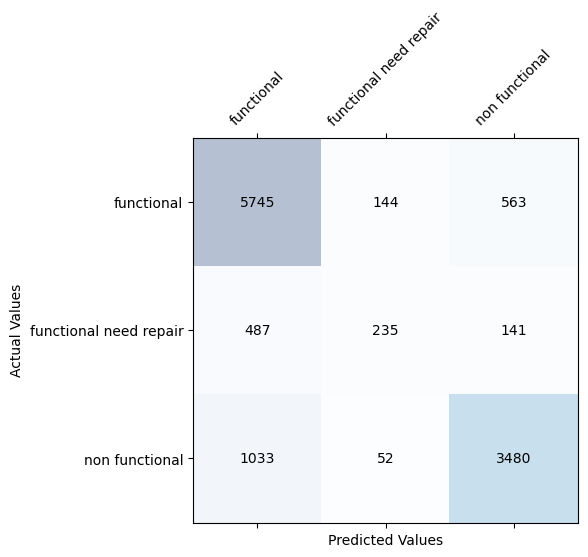

In [56]:
# Fit Random Forest Classification with the best parameter 
rf= RandomForestClassifier(class_weight= 'balanced', criterion= 'gini', max_features= 'auto', n_estimators= 64, random_state= 42)

rf.fit(Xs_train, y_train)
y_pred =rf.predict(Xs_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
        s=cm[i, j],
        va='center', ha='center')

classes=["functional","functional need repair","non functional"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

print(classification_report(y_test, y_pred))

___
**4.3.2 XGBoost**

In [57]:
dtrain = xgb.DMatrix(X_train, label=y_train)
class_weights = compute_sample_weight('balanced', y_train)

In [58]:
# # XGBoost Classification model initialisation
# xgboost_clf = xgb.XGBClassifier(seed=42)

# # XGBoost Classification model's parameter grid
# f_xgboost_search = GridSearchCV(xgboost_clf,
#                             param_grid={'seed': [42],
#                                         'max_depth': [10,15,20,25],
#                                         'colsample_bytree': [0.75],
#                                         'subsample': [0.5],
#                                         'gamma': [0,1],
#                                         'learning_rate': [0.01,0.1],
#                                         'objective' : ['multi:softmax']
#                                         },
#                             scoring='accuracy',
#                            verbose=3)

# # Run fit with all sets of parameters
# f_xgboost_search.fit(Xs_train, y_train,sample_weight=class_weights)

# print("Best parameter for XGBoost Classification ", f_xgboost_search.best_params_)
# print("Accuracy: ", f_xgboost_search.best_score_, "\n")

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      6452
           1       0.45      0.38      0.41       863
           2       0.82      0.78      0.80      4565

    accuracy                           0.79     11880
   macro avg       0.69      0.67      0.68     11880
weighted avg       0.79      0.79      0.79     11880



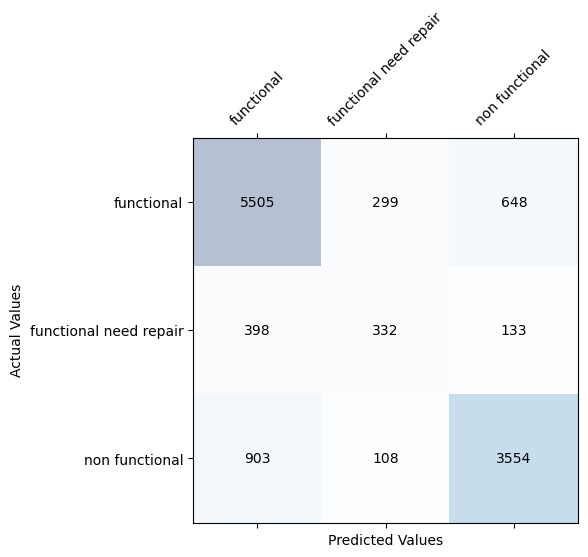

In [59]:
# Fit XGBoost Classification with the best parameter 
xgboost = xgb.XGBClassifier(colsample_bytree= 0.75, gamma= 0, learning_rate= 0.1, max_depth= 25, objective= 'multi:softproba', seed= 42, subsample= 0.5)

xgboost.fit(Xs_train, y_train,sample_weight=class_weights)
y_pred =xgboost.predict(Xs_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
        s=cm[i, j],
        va='center', ha='center')

classes=["functional","functional need repair","non functional"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

print(classification_report(y_test, y_pred))

___
**4.3.3 CatBoost**

In [60]:
# catboost_clf = CatBoostClassifier(random_seed=42)

# # CatBoost Classification model's parameter grid
# f_catboost_search = GridSearchCV(catboost_clf,
#                             param_grid={'loss_function': ['MultiClass'],
#                                         'random_seed': [42],
#                                         'learning_rate': [0.01,0.1],
#                                         'depth': [4,8,12,16],
#                                         'iterations': [100]
#                                         },
#                             scoring='accuracy',
#                            verbose=3)

# # Run fit with all sets of parameters
# f_catboost_search.fit(Xs_train, y_train)

# print("Best parameter for CatBoost Classification ", f_catboost_search.best_params_)
# print("Accuracy: ", f_catboost_search.best_score_, "\n")

              precision    recall  f1-score   support

           0       0.76      0.91      0.83      6452
           1       0.59      0.19      0.28       863
           2       0.84      0.71      0.77      4565

    accuracy                           0.78     11880
   macro avg       0.73      0.60      0.63     11880
weighted avg       0.78      0.78      0.77     11880



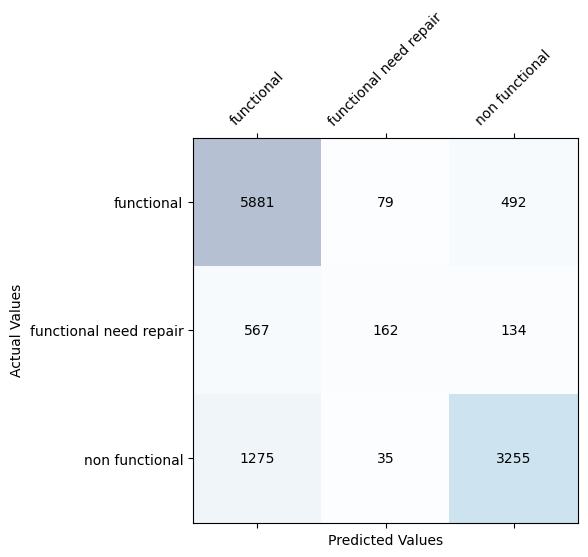

In [61]:
# Fit CatBoost Classification with the best parameter 
catboost = CatBoostClassifier(depth= 16, iterations=100, learning_rate= 0.1, loss_function= 'MultiClass', random_seed= 42, verbose=0)

catboost.fit(Xs_train, y_train)
y_pred =catboost.predict(Xs_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
        s=cm[i, j],
        va='center', ha='center')

classes=["functional","functional need repair","non functional"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

print(classification_report(y_test, y_pred))

___
**4.3.4 K-Fold CV**

In [62]:
models = []
models.append(("Random Forest", rf))
models.append(("XGBoost", xgboost))
models.append(("CatBoost", catboost))

# Test options and evaluation metric
num_folds = 5
num_instances = len(Xs_train)
scoring = "accuracy"
results = []
names = []

for name, model in models:
    kf = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, Xs_train, y_train, cv=kf, scoring=scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    
print("5-Fold cross-validation accuracy score for the training data for all the classifiers")

for name, cv_results in zip(names, results):
    print("%-15s: %.6f (%.6f)" % (name, cv_results.mean(), cv_results.std()))

5-Fold cross-validation accuracy score for the training data for all the classifiers
Random Forest  : 0.795370 (0.003575)
XGBoost        : 0.799642 (0.002589)
CatBoost       : 0.786785 (0.004328)


___
**4.3.5 ROC Curve**

In [63]:
def roc(model_name):
    classifier = model_name
    y_score = classifier.fit(Xs_train, y_train).predict_proba(Xs_test)

    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    n_classes = y_test_bin.shape[1]



    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = cycle(['blue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

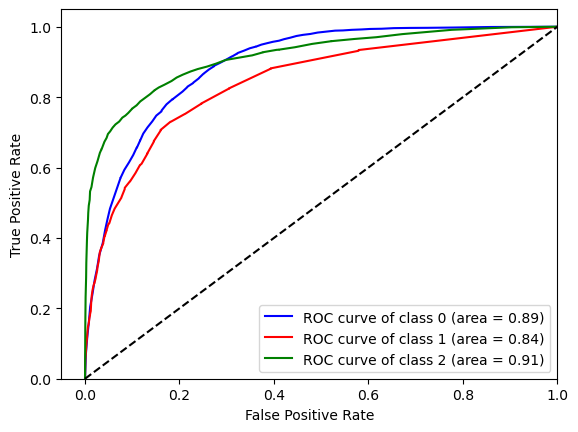

In [64]:
roc(rf)

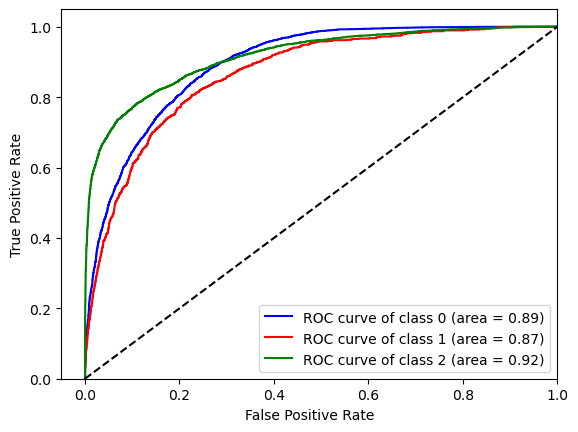

In [65]:
roc(xgboost)

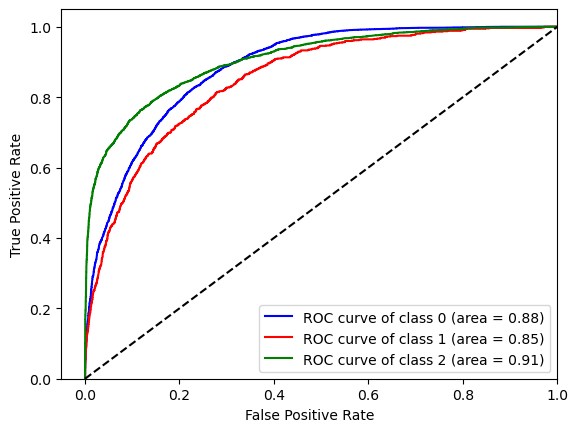

In [66]:
roc(catboost)